# Model Training Without Debiasing

## Importing libraries and assets

In [ ]:
# ref: https://github.com/Rak5hith-S/Visual_Question_Answering/blob/main/notebooks/2.%20Preprocessing%20and%20Model%20Training.ipynb

import collections
import contractions
import joblib
import json
import nltk
import random
import re
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sentence_transformers import SentenceTransformer
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (
    Embedding, LSTM, SpatialDropout1D, Input, concatenate, Dense, Multiply, 
    BatchNormalization, Dropout
)
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
)
from tensorflow.keras.applications import xception
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2025-03-28 19:18:46.044611: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 19:18:46.083074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9


2025-03-28 19:18:50.760237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:18:50.761840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:18:50.761871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:18:50.761964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Setup NLTK Tokenizers

In [2]:
nltk.data.path.append('./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')
nltk.download('punkt_tab', download_dir='./nltk_data')

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Tensorflow Version and GPU Availability

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation and Preprocessing 

### Loading and Filtering Dataset

- As it was done in the EDA the dataset is loaded and filtered out the samples whose answers belong to the top-100 most frequent one-word answers.

In [4]:
def load_vqa_data(annotations_path, questions_path):
    """
    Loads VQA dataset components: annotations and questions.

    Parameters:
        annotations_path (str): Path to the annotations JSON file.
        questions_path (str): Path to the questions JSON file.

    Returns:
        tuple: (annotations dictionary, questions dictionary)
    """

    # load annotations
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    # load questions
    with open(questions_path, 'r') as f:
        questions = json.load(f)

    return annotations, questions

def process_vqa_data(questions, answers, img_dir):
    """
    Converts VQA JSON annotations into a structured DataFrame.

    Parameters:
        questions (dict): JSON object containing the questions.
        answers (dict): JSON object containing the annotations (answers).
        img_dir (str): Directory containing the images.

    Returns:
        pd.DataFrame: Processed DataFrame with image paths, questions, and answers.
    """

    # convert JSON data to DataFrames
    questions_df = pd.DataFrame.from_records(questions['questions'])
    answers_df = pd.DataFrame.from_records(answers['annotations'])

    # merge the DataFrames on 'image_id' and 'question_id'
    df = pd.merge(questions_df, answers_df, how='left', on=['image_id', 'question_id'])

    # extract a list of 10 answers per question
    df['answers'] = [[ans['answer'] for ans in ans_list] for ans_list in df['answers']]

    # construct image file paths based on 'image_id'
    df['image_path'] = "COCO_" + answers['data_subtype'] + "_" + df['image_id'].astype(str).str.zfill(12) + ".jpg"
    df['image_path'] = os.path.join(img_dir, '') + df['image_path']

    # reorder columns: Move 'image_path' to the first position
    df = df[['image_path'] + list(df.columns[:-1])]

    # drop unwanted columns
    df.drop(['image_id', 'question_id'], axis=1, inplace=True)

    return df

def filter_one_word_answers(df, top_n=100):
    """
    Filters the dataset to include only samples with one-word answers 
    and keeps only the top N most frequent one-word answers.

    Parameters:
        df (pd.DataFrame): The training dataset containing a 'multiple_choice_answer' column.
        top_n (int): The number of most frequent one-word answers to retain.

    Returns:
        pd.DataFrame: The filtered dataset.
    """

    # count words in each answer
    ans_word_count = df['multiple_choice_answer'].apply(lambda x: len(word_tokenize(x)))

    # filter for one-word answers
    df = df[ans_word_count == 1]

    # compute frequency of one-word answers
    one_word_ans_freq = df['multiple_choice_answer'].value_counts()

    # print total unique one-word answers
    print("Total number of unique one-word answers:", one_word_ans_freq.keys().nunique())

    # select the top N most frequent one-word answers
    top_answers = one_word_ans_freq.nlargest(top_n).index

    # filter the dataset for answers in the top N
    df = df[df['multiple_choice_answer'].isin(top_answers)]

    # print final dataset shape
    print(f"Filtered DataFrame shape: {df.shape}")

    return df

In [5]:
img_dir = "Datasets/VQAv2/InputImages/training-images/train2014"
answers, questions = load_vqa_data('Datasets/VQAv2/Annotations/TrainingAnnotations/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json', 
                                           'Datasets/VQAv2/InputQuestions/TrainingQuestions/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json')

In [6]:
print("Dataset\n")
print("Total number of images: ", len(os.listdir(img_dir)))
print("Total number of questions: ", len(questions['questions']))
print("Total number of answer annotations: ", len(answers['annotations']))
print("Total number of answers(not unique) given for a question: ",
      len(answers['annotations'][0]['answers']))

Dataset

Total number of images:  82783
Total number of questions:  443757
Total number of answer annotations:  443757
Total number of answers(not unique) given for a question:  10


In [7]:
data_df = process_vqa_data(questions, answers, img_dir)

In [8]:
data_df.head()

,image_path,question,question_type,multiple_choice_answer,answers,answer_type
0,../../Datasets/VQAv2/InputImages/training-imag...,What is this photo taken looking through?,what is this,net,"[net, net, net, netting, net, net, mesh, net, ...",other
1,../../Datasets/VQAv2/InputImages/training-imag...,What position is this man playing?,what,pitcher,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",other
2,../../Datasets/VQAv2/InputImages/training-imag...,What color is the players shirt?,what color is the,orange,"[orange, orange, orange, orange, orange, orang...",other
3,../../Datasets/VQAv2/InputImages/training-imag...,Is this man a professional baseball player?,is this,yes,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",yes/no
4,../../Datasets/VQAv2/InputImages/training-imag...,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other


In [9]:
data_df = filter_one_word_answers(data_df, top_n=100)

Total number of unique one-word answers: 10223
Filtered DataFrame shape: (307568, 6)


### Dataset Sampling

- The original dataset contains over 300,000 samples, which was too resource-intensive to process due to compute and memory constraints.

- To make training more manageable, the dataset was downsampled to 64,000 samples.

- The 64K subset was split into:

    - 51,200 samples for training (80%)

    - 12,800 samples for validation (20%)

- The 51,200 training samples were chosen specifically to allow for a batch size of 1,024, resulting in exactly 50 steps per epoch (51,200 / 1,024 = 50).

- Stratified sampling was used during selection to maintain the original distribution of answer_type categories in both training and validation sets.

In [10]:
data_df, _ = train_test_split(
    data_df,
    train_size=64000,
    stratify=data_df['answer_type'],
    random_state=30
)
data_df.shape


(64000, 6)

#### Distribution of answer_types in the Sampled Dataset

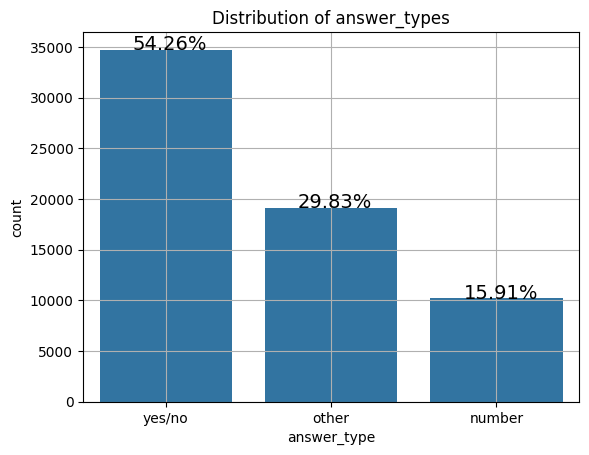

In [11]:
ax = sns.countplot(data=data_df, x='answer_type')

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(data_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.title("Distribution of answer_types")
plt.grid()
plt.show()

### Textual Data Cleaning (Questions)

- The released annotations have already undergone several preprocessing steps on the raw crowdsourced data, including:

    - Spelling correction applied to both questions and answers using Bing Speller.

    - Question normalization, which involves capitalizing the first character and ensuring the question ends with a question mark.

    - Answer normalization, which includes:

        - Converting all characters to lowercase.

        - Removing periods, except when used as decimal points.

        - Replacing number words with digits.

        - Removing articles such as "a," "an," and "the."
        
    - Adding apostrophes in cases where contractions were missing them (e.g., converting "dont" to "don't").

Source: [[link](https://visualqa.org/download.html#:~:text=from%20here.-,Overview,-The%20annotations%20we)]

#### Further Cleaning and Contraction Handling

- In addition to the provided preprocessing, I further clean the questions by:

    - Expanding contractions using the Python contractions module (alternatives include pycontractions and others).

    - Converting text to lowercase.
    
    - Removing any special characters or non-alphanumeric symbols to standardize the text.

In [12]:
def clean_text(text):
    """
    Cleans the given text by expanding contractions, converting to lowercase, 
    and removing non-alphanumeric characters.

    Parameters:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    text = contractions.fix(text)  # expand contractions
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # remove non-alphanumeric characters
    return text.strip()  # remove leading/trailing spaces

In [13]:
data_df['question'] = data_df['question'].apply(lambda x: clean_text(x))
data_df['question'].sample(10)

210330                               are these wild animals
331049                           is the water safe to drink
220146                       what sport does the woman play
393317                              what is the man holding
111133                                what is the man doing
333741                        what color is the teddy s bow
274551    what would you do if you came up to this sign ...
11525                              how many laps do you see
111019                 do you an onion on one of the pizzas
124307                   is somebody celebrating a birthday
Name: question, dtype: object

### Train-Val Splitting:

- A stratified split is applied to partition the data into 80% training and 20% validation sets, ensuring the class distribution remains consistent across both subsets.

In [14]:
train_df, val_df = train_test_split(
    data_df,
    train_size=0.8,
    stratify=data_df['answer_type'],
    random_state=30
)

print("Shape of train data: ", train_df.shape)
print("Shape of validation data: ", val_df.shape)


Shape of train data:  (51200, 6)
Shape of validation data:  (12800, 6)


In [ ]:
# Saving train data
train_df.to_csv('./train_df.csv', index=False)

# Saving val data
val_df.to_csv('./val_df.csv', index=False)

In [ ]:
# load train data
train_df = pd.read_csv('./train_df.csv')

# load val data
val_df = pd.read_csv('./val_df.csv')

#### Distribution of answer_types in Training and Validation Sets

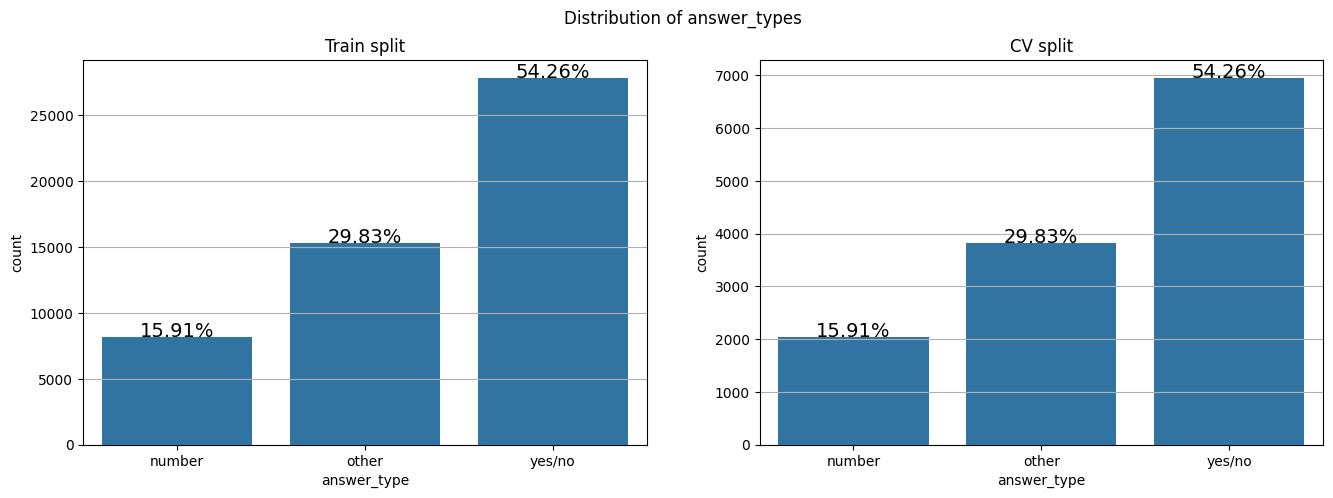

In [17]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.grid()
plt.title("Train split")
ax = sns.countplot(data=train_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(train_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.subplot(1,2,2)
plt.grid()
plt.title("CV split")
ax = sns.countplot(data=val_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(val_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.suptitle("Distribution of answer_types")
plt.show()

### One-Hot Encode Answers

In [18]:
ohe=OneHotEncoder(sparse_output=False)
ohe.fit(train_df['multiple_choice_answer'].values.reshape(-1,1))

OneHotEncoder(sparse_output=False)

In [19]:
print("Number of answers: ", len(ohe.categories_[0]))
print("Answers: ", ohe.categories_)

Number of answers:  100
Answers:  [array(['0', '1', '10', '11', '12', '2', '20', '3', '4', '5', '6', '7',
       '8', '9', 'apple', 'banana', 'baseball', 'bathroom', 'beach',
       'bear', 'black', 'blue', 'brick', 'broccoli', 'brown', 'bus',
       'cake', 'camera', 'car', 'cat', 'clear', 'cow', 'dog', 'donut',
       'eating', 'elephant', 'female', 'flowers', 'food', 'frisbee',
       'giraffe', 'grass', 'gray', 'green', 'hat', 'horse', 'kitchen',
       'kite', 'laptop', 'left', 'male', 'man', 'many', 'metal',
       'motorcycle', 'no', 'none', 'nothing', 'orange', 'outside',
       'phone', 'pink', 'pizza', 'plane', 'purple', 'red', 'right',
       'sandwich', 'sheep', 'silver', 'sitting', 'skateboard',
       'skateboarding', 'skiing', 'snow', 'snowboarding', 'soccer',
       'standing', 'stop', 'summer', 'sunny', 'surfboard', 'surfing',
       'table', 'tan', 'tennis', 'tile', 'train', 'trees', 'umbrella',
       'walking', 'water', 'white', 'wii', 'wine', 'winter', 'woman',
   

In [20]:
# saving One-Hot Encoder
joblib.dump(ohe, "ohe.joblib")
ohe = joblib.load("ohe.joblib")

## Modeling

The Visual Question Answering (VQA) task is addressed through a multi-step modeling pipeline, which includes the following key components:

1. **Image Feature Extraction**  
   - Images are processed using a pre-trained **Xception** model.  
   - Features are extracted from the second-to-last layer, providing a compact, high-level representation of the visual content relevant for answering questions.

2. **Question Feature Encoding**  
   - Questions are encoded using **Sentence-BERT (SBERT)**, producing dense semantic embeddings that capture the meaning of each question.  
   - Additional text preprocessing is performed to clean and standardize the input before encoding.

3. **Joint Feature Fusion**  
   - Image and question features are combined through **element-wise (pointwise) multiplication**.  
   - This fusion technique creates a joint representation that integrates both modalities, enabling the model to reason over combined visual and textual information.

5. **Answer Prediction**  
   - The joint feature representation is passed through fully connected layers with **batch normalization** and **dropout** for regularization.  
   - The model outputs a probability distribution over the top **100** most frequent one-word answers using a **softmax** classifier.

### Callbacks for Model Training

- These callbacks are used to monitor and control the training process, adjusting learning rates, handling early stopping, and ensuring stability during training.

#### Learning Rate Scheduling

- Reduces the learning rate by a fixed decay rate after each epoch.

In [21]:
def exp_decay(epoch, lr):
    """
    Applies exponential decay to the learning rate.

    This function reduces the learning rate by a fixed decay rate 
    after each epoch to allow the optimizer to make finer updates 
    as training progresses.

    Args:
        epoch (int): The current training epoch.
        lr (float): The current learning rate.

    Returns:
        float: The updated learning rate after applying decay.
    """
    decay_rate = 0.96  # Reduce LR by 4% per epoch
    return lr * decay_rate

lrschedule = LearningRateScheduler(exp_decay, verbose=1)


#### Reduce Learning Rate on Plateau

- Lowers the learning rate when validation accuracy stops improving.

In [22]:
reduce_lr_on_acc = ReduceLROnPlateau(factor=0.9, monitor='val_accuracy', patience=1, verbose=1, mode='max')

#### Custom Callback to Terminate on NaN or Infinite Loss

- Monitors training for unstable behavior such as NaN or infinite loss/weights.

In [23]:
class TerminateNaN(tf.keras.callbacks.Callback):
    """
    Custom Keras callback to terminate model training when NaN or infinite values 
    are detected in the loss or model weights.

    This callback ensures training stability by:
    - Monitoring the loss at the end of each epoch.
    - Monitoring model weights after each epoch.
    - Automatically stopping training when an invalid value (NaN or infinity) is found.

    Useful in preventing wasted compute resources when training becomes unstable.

    Parameters
    ----------
    None

    Methods
    -------
    on_epoch_end(epoch, logs=None)
        Checks the training loss and model weights for NaN or infinite values
        at the end of each epoch and stops training if any are found.
    """

    def on_epoch_end(self, epoch, logs={}):
        """
        Checks loss and model weights for NaN or infinity at the end of each epoch.
        Stops training if invalid values are found.
        """
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

        weights= self.model.get_weights()
        for i in weights:
            if np.isnan(np.sum(i)):
                print("Invalid weights and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

terminate_nan = TerminateNaN()

#### Early Stopping

- Stops training early if validation accuracy doesn't improve over a specified number of epochs.

In [24]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

### SBERT-Based Question Encoding

- Generates semantic embeddings of the input questions using a pre-trained Sentence-BERT (SBERT) model. These embeddings are dense vector representations that capture the meaning of the question, making them suitable for integration with image features in the VQA model.

In [25]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def encode_questions_sbert(sbert_model, text):
    """
    Encodes a question into a dense vector representation using Sentence-BERT (SBERT).

    Cleans the input text and converts it into a semantic embedding 
    suitable for input into the VQA model.

    Args:
        sbert_model (SentenceTransformer): Pre-trained SBERT model used for encoding.
        text (str): Raw question text.

    Returns:
        numpy.ndarray: SBERT embedding of the input question, 
                       typically of shape (1, embedding_dim).
    """
    text = clean_text(text)
    sbert_embedding = sbert_model.encode([text])
    return sbert_embedding


### Image Feature Extraction and Encoding (Using Xception)

#### Preprocessing Images

- The input images are resized to a target size of (299, 299), which matches the required input dimensions for the Xception model (tf.keras.applications.xception.Xception).

- This preprocessing step scales the pixel values to the range [-1, 1], which is the expected input format for the Xception model.

- Unlike some other models (e.g., ResNet), Xception does not convert images from RGB to BGR or apply mean subtraction relative to ImageNet statistics. Instead, it normalizes pixel values to center them around zero by scaling.

In [26]:
IMG_TARGET_SIZE = (299, 299)

In [27]:
def preprocess_image_for_xception(img_path, target_size):
    """
    Loads and preprocesses an image for input into the Xception model.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): The desired size for the input image.

    Returns:
        numpy.ndarray: Preprocessed image array, ready for feature extraction.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # Xception's preprocess_input scales pixels to the range [-1, 1]
    img_arr = xception.preprocess_input(img_arr)
    return img_arr

#### Xception Model to Featurize Images

- A pre-trained Xception model is loaded using tf.keras.applications.xception.Xception, with ImageNet weights and an input shape of (299, 299, 3) to match the required image dimensions.

- The model’s layers are frozen (trainable = False) to prevent them from being updated during training, ensuring that the extracted features remain consistent and leverage the knowledge learned from ImageNet.

- A separate feature extractor model, xception_featurizer, is created by specifying the inputs of the original Xception model and the outputs of its second-to-last layer.

- This layer provides a 2048-dimensional feature vector that serves as a compact and informative embedding of the input image.
The feature extractor model (xception_featurizer) is also frozen to avoid unintentional updates.

In [ ]:
xception_model = xception.Xception(
    weights='imagenet',
    input_shape=IMG_TARGET_SIZE + (3,)
)
xception_model.trainable = False

# create a model that outputs activations from Xception's second-to-last layer
xception_featurizer = Model(
    inputs=xception_model.inputs, 
    outputs=xception_model.layers[-2].output
)
xception_featurizer.trainable = False

# (Optional) view the model summary
xception_featurizer.summary()


2025-03-28 19:21:10.905519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:21:10.905638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:21:10.905658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:21:10.905952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 19:21:10.905987: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

#### Encoding Images Using the Xception Featurizer

- Generates a 2048-dimensional feature vector for a given image using the pre-trained Xception feature extractor.

In [29]:
def encode_image_with_xception(xception_featurizer, img_path, target_size):
    """
    Encodes an image into a feature vector using a pre-trained Xception model.
    
    Args:
        xception_featurizer (tf.keras.Model): Feature extractor model.
        img_path (str): Path to the image file.
        target_size (tuple): Target size for image preprocessing.

    Returns:
        numpy.ndarray: Encoded feature vector representing the input image.
    """
    # Preprocess the image using the updated function
    img_arr = preprocess_image_for_xception(img_path, target_size)
    # Expand dimensions and pass through the featurizer
    xception_feats = xception_featurizer(np.expand_dims(img_arr, axis=0))
    return xception_feats


### DataLoaders for Model Training and Validation

- CustomDatasetModel handles the retrieval and preprocessing of individual question-image-answer samples, including SBERT question encoding, Xception image feature extraction, and one-hot answer encoding.

- CustomDataLoader batches these preprocessed samples, manages data shuffling, and feeds them efficiently to the model during training and validation using TensorFlow's Sequence interface.

In [ ]:
class CustomDatasetModel:
    """
    Custom Dataset Model for Multimodal Visual Question Answering (VQA).

    This dataset processes each sample by:
    - Encoding natural language questions into dense embeddings using Sentence-BERT (SBERT).
    - Extracting image features from preprocessed images using the pre-trained Xception model.
    - One-hot encoding the answers for classification.

    Suitable for multimodal learning tasks combining image and text features.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the dataset with columns: 'question', 'image_path', and 'multiple_choice_answer'.
    sbert_model : SentenceTransformer
        Pre-trained SBERT model for encoding the questions.
    xception_featurizer : tf.keras.Model
        Pre-trained Xception model providing image feature vectors.
    img_target_size : tuple of int
        Desired size for the image input (height, width).
    ohe : sklearn.preprocessing.OneHotEncoder
        One-hot encoder fitted on the answer categories.

    Methods
    -------
    __getitem__(index)
        Returns a tuple of (question_embedding, image_features, one_hot_encoded_answer).
    
    __len__()
        Returns the total number of samples in the dataset.
    """

    def __init__(self, data, sbert_model, xception_featurizer, img_target_size, ohe):
        self.length = len(data)
        self.questions = data['question'].values
        self.images = data['image_path'].values
        self.answers = data['multiple_choice_answer'].values
        
        self.sbert_model = sbert_model
        self.xception_featurizer = xception_featurizer
        self.img_target_size = img_target_size
        self.ohe = ohe

    def __getitem__(self, index):
        """
        Retrieves and encodes a single sample.
        """
        # encode question with SBERT
        encoded_question = encode_questions_sbert(self.sbert_model, self.questions[index])[0]

        # extract image features with Xception
        encoded_image = encode_image_with_xception(
            self.xception_featurizer,
            self.images[index],
            self.img_target_size
        )[0]

        # One-hot encode answer
        encoded_answer = self.ohe.transform(np.asarray([[self.answers[index]]]))[0]

        return encoded_question, encoded_image, encoded_answer

    def __len__(self):
        """
        Returns the number of samples.
        """
        return self.length

In [31]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence  
class CustomDataLoader(tf.keras.utils.Sequence):
    """
    Custom DataLoader for batching multimodal data in Visual Question Answering (VQA).

    This DataLoader works with `CustomDatasetModel` (or similar datasets) that return
    pre-processed question embeddings, image features, and one-hot encoded answers.

    It creates batches of data, shuffles them if specified, and works seamlessly with
    `tf.keras` training loops such as `model.fit()`.

    Parameters
    ----------
    dataset : CustomDatasetModel
        The dataset instance that provides individual samples of question embeddings,
        image features, and answers.
    batch_size : int, optional (default=1)
        Number of samples per batch.
    shuffle : bool, optional (default=True)
        Whether to shuffle the dataset at the beginning of training.
    shuffle_every_epoch : bool, optional (default=False)
        Whether to reshuffle the dataset at the end of every epoch.

    Methods
    -------
    __getitem__(index)
        Retrieves and returns a batch of data at the specified index.
        
    __len__()
        Returns the total number of batches per epoch.
        
    on_epoch_end()
        Shuffles the dataset at the end of each epoch if `shuffle_every_epoch` is True.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=True, shuffle_every_epoch=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_every_epoch = shuffle_every_epoch
        self.indexes = np.arange(len(dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
 
    def __getitem__(self, index):
        """
        Returns a single batch of data.
        """
        start = index * self.batch_size
        stop = (index + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([[batch[0],batch[1]],batch[2]])
    
    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """
        Shuffles data after each epoch if shuffle_every_epoch is enabled.
        """
        if self.shuffle_every_epoch:
            self.indexes = np.random.permutation(self.indexes)

#### Training and Validation Datasets and Dataloaders

In [32]:
# creating train and validation dataset
train_dataset = CustomDatasetModel(
    train_df, sbert_model, xception_featurizer, IMG_TARGET_SIZE, ohe
)

val_dataset = CustomDatasetModel(
    val_df, sbert_model, xception_featurizer, IMG_TARGET_SIZE, ohe
)

BATCH_SIZE = 1024

# creating data loaders
train_dataloader = CustomDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
val_dataloader = CustomDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)


In [33]:
features, answers = train_dataloader[0]
question_features, image_features = features

print("Batch shape of question features:", question_features.shape)
print("Batch shape of image features:", image_features.shape)
print("Batch shape of one-hot encoded answers:", answers.shape)

2025-03-28 19:21:20.896785: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-03-28 19:21:20.905828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


Batch shape of question features: (1024, 384)
Batch shape of image features: (1024, 2048)
Batch shape of one-hot encoded answers: (1024, 100)


## Model Training

### TensorBoard Callback

- TensorBoard callback to visualize logs during training

In [34]:
log_dir="./model_logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

### ModelCheckpoint Callback

- Model checkpoint to save the best model based on validation accuracy

In [35]:
checkpoint = ModelCheckpoint(
    filepath="./best_model.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [36]:
# clear any logs from previous runs
!rm -rf './model_logs/'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


###  Model Construction: Multimodel Fusion & Prediction

In [ ]:
# ========================================================
#                  MODEL INPUTS AND FEATURE ENCODING
# ========================================================

# Question Feature Encoding 
ques_input = Input(shape=(384, ), name='sbert_embedding')
print("Question Input Shape:", ques_input.get_shape())

ques_features = Dense(
    512, 
    activation='relu', 
    name='ques_dense', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=33)
)(ques_input)
print("Question Features Shape:", ques_features.get_shape()) 

# Image Feature Encoding 
img_input = Input(shape=(2048,), name='xception_activations')
print("Image Input Shape:", img_input.get_shape())

# Normalize image feature vectors
l2_normed_resnet_features = tf.math.l2_normalize(
    img_input, axis=1, epsilon=1e-12, name='l2_norm'
)
print("L2 Normalized Image Features Shape:", l2_normed_resnet_features.get_shape())

# Dense layers on image features
img_dense_1 = Dense(
    1024, 
    activation='relu', 
    name='img_dense_1',
    kernel_initializer=tf.keras.initializers.he_normal(seed=36),
)(l2_normed_resnet_features)
print("Image Dense Layer 1 Shape:", img_dense_1.get_shape())

img_features = Dense(
    512, 
    activation='relu', 
    name='img_dense_2', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=39)
)(img_dense_1)
print("Image Dense Layer 2 Shape:", img_features.get_shape())

# ========================================================
#                  MULTIMODAL FUSION AND OUTPUT
# ========================================================

# Combine question and image features through pointwise multiplication
joint_feat_rep = Multiply(name='pointwise-multiplication')([ques_features, img_features])
print("Joint Feature Representation Shape:", joint_feat_rep.get_shape())

# Apply batch normalization and dropout for regularization
batch_norm_1 = BatchNormalization(name='batch_norm_1')(joint_feat_rep)
drop_out_1 = Dropout(0.2, name='dropout_1')(batch_norm_1)

# Additional dense layer for learning joint representations
d1=Dense(
    256, 
    activation='relu', 
    name='dense_1', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=30)
)(drop_out_1)

# Final softmax layer for answer classification
final_output = Dense(
    100, 
    activation='softmax', 
    name='softmax_classification', 
    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3)
)(d1)
print("Final Output Shape:", final_output.get_shape())

# ========================================================
#                  COMPILE THE MODEL
# ========================================================
model = Model(inputs=[ques_input, img_input], outputs=final_output)
print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.002, weight_decay=1e-5),
    metrics=['accuracy']
)

# ========================================================
#                  MODEL TRAINING
# ========================================================
history = model.fit(
    train_dataloader, 
    steps_per_epoch=50,
    epochs=20,  
    validation_data=val_dataloader, 
    validation_steps=12,
    callbacks=[lrschedule, terminate_nan, earlystop, tensorboard_callback, checkpoint]
)

Question Input Shape: (None, 384)
Question Features Shape: (None, 512)
Image Input Shape: (None, 2048)
L2 Normalized Image Features Shape: (None, 2048)
Image Dense Layer 1 Shape: (None, 1024)
Image Dense Layer 2 Shape: (None, 512)
Joint Feature Representation Shape: (None, 512)
Final Output Shape: (None, 100)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xception_activations (Inpu  [(None, 2048)]               0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.l2_normalize (TFOp  (None, 2048)                 0         ['xception_activations[0][0]']
 Lambda)                                                                      

I0000 00:00:1742465433.443299     150 service.cc:145] XLA service 0x7fb2f800f6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742465433.443349     150 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-03-20 10:10:33.456025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742465433.523272     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - ETA: 0s - loss: 1.9301 - accuracy: 0.3639     
Epoch 1: val_accuracy improved from -inf to 0.38908, saving model to ./best_model.keras
50/50 [==============================] - 5218s 104s/step - loss: 1.9301 - accuracy: 0.3639 - val_loss: 1.6447 - val_accuracy: 0.3891 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0018432000651955605.
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.3422 - accuracy: 0.4445   
Epoch 2: val_accuracy improved from 0.38908 to 0.42383, saving model to ./best_model.keras
50/50 [==============================] - 4398s 88s/step - loss: 1.3422 - accuracy: 0.4445 - val_loss: 1.5187 - val_accuracy: 0.4238 - lr: 0.0018

Epoch 3: LearningRateScheduler setting learning rate to 0.001769472062587738.
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 1.2234 - accuracy: 0.4877     
Epoch 3: val_accuracy improved from 0.42383 to 0.43978, saving model to ./best_model.ke

## Model Evaluation

- Evaluates the model’s accuracy for each answer type (e.g., "yes/no", "number", "other").

In [36]:
model = load_model('./best_model.keras')

In [35]:
loss, accuracy = model.evaluate(val_dataloader, verbose=0)

2025-03-23 20:23:30.101719: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-03-23 20:23:30.109455: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f7d8ca509d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f7d8ca509d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
print(f"Val Loss: {loss:.4f}")
print(f"Val Accuracy: {accuracy:.4f}")

Val Loss: 1.8234
Val Accuracy: 0.4729


In [37]:
y_preds, y_trues = [], []

for (x, y) in val_dataloader:
    pred = model.predict(x)
    y_preds.extend(np.argmax(pred, axis=1))
    y_trues.extend(np.argmax(y, axis=1))

32/32 [==============================] - 0s 2ms/step


### Confusion Matrix Top K Answers

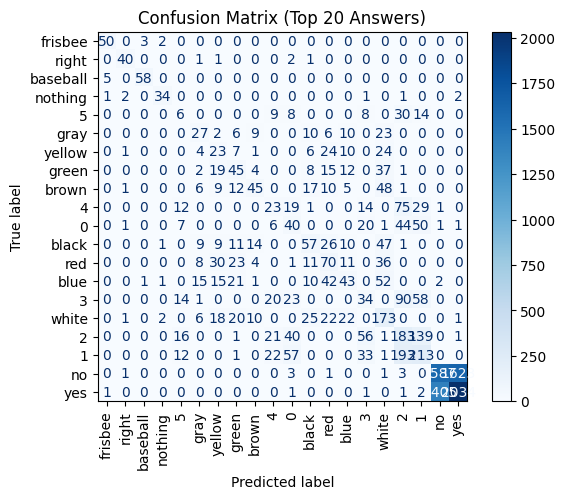

In [38]:
def plot_confusion_matrix(y_true, y_pred, ohe, top_k=20):
    cm = confusion_matrix(y_trues, y_preds)
    top_labels = np.argsort(cm.sum(axis=1))[-top_k:]
    cm_top = cm[top_labels][:, top_labels]
    labels = ohe.categories_[0][top_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels)
    disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix (Top {top_k} Answers)')
    plt.show()

plot_confusion_matrix(y_trues, y_preds, ohe, top_k=20)

### Class-wise Accuracy

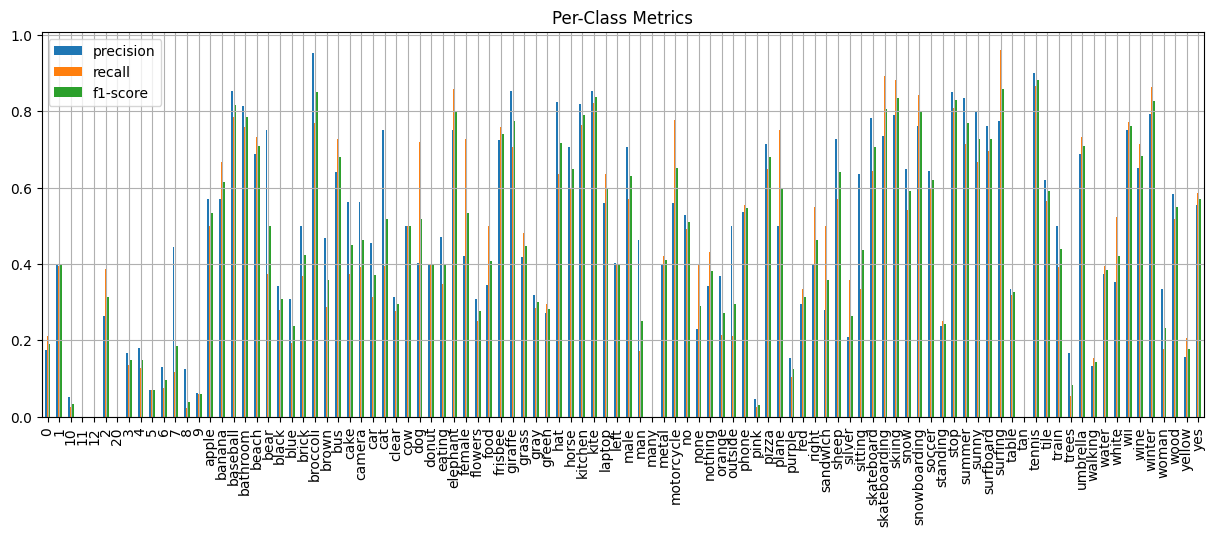

In [39]:
report = classification_report(y_trues, y_preds, target_names=ohe.categories_[0], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(15, 5))
plt.title("Per-Class Metrics")
plt.grid()
plt.show()

### Image-Question-Answer Examples

1/1 [==============================] - 0s 18ms/step


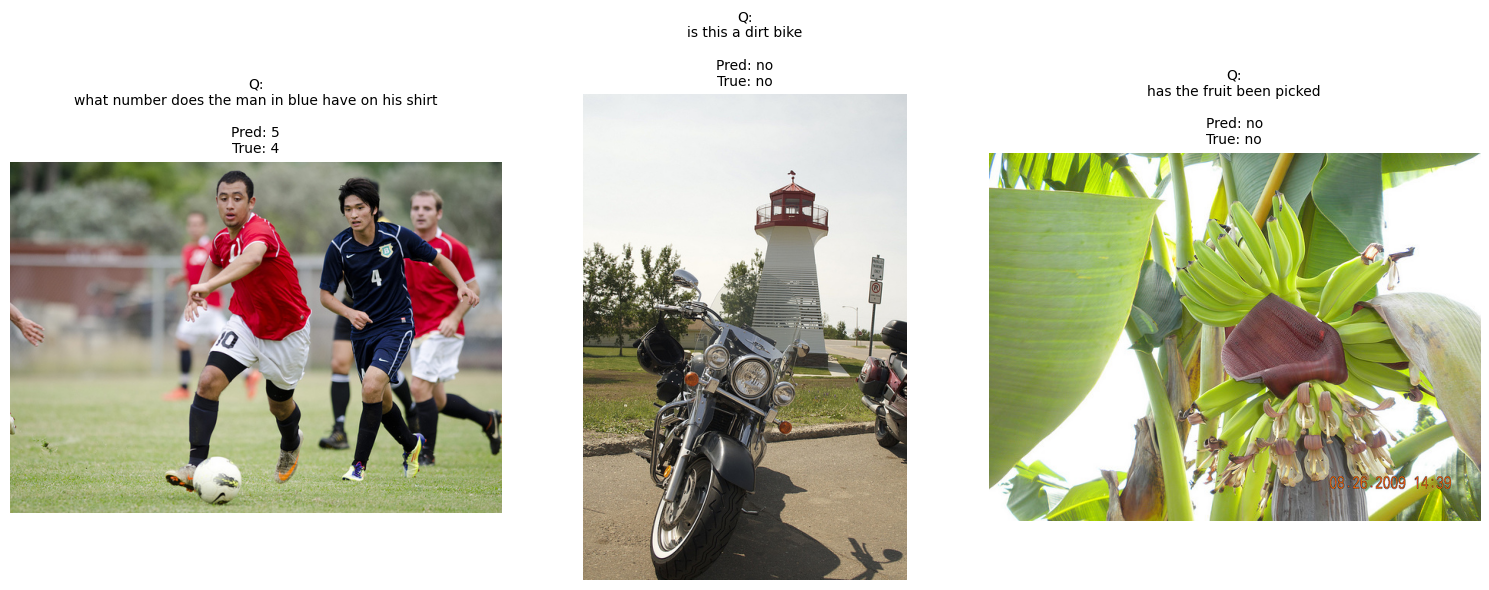

In [40]:
num_samples = 3

sample_idxs = random.sample(range(len(val_dataset)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 6))

for i, idx in enumerate(sample_idxs):
    q_feat, img_feat, gt_ans = val_dataset[idx]
    pred = model.predict([[q_feat[np.newaxis, ...], img_feat[np.newaxis, ...]]])
    pred_label = ohe.categories_[0][np.argmax(pred)]
    true_label = val_dataset.answers[idx]

    img_path = val_dataset.images[idx]
    img = image.load_img(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"Q:\n{val_dataset.questions[idx]}\n\nPred: {pred_label}\nTrue: {true_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### t-SNE Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


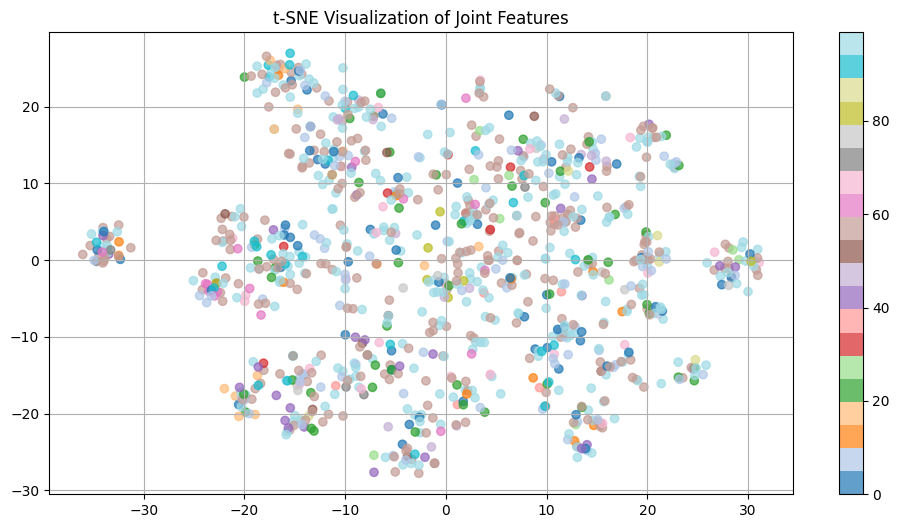

In [41]:
questions, images, labels = [], [], []
for i in range(1000):
    q, img, a = val_dataset[i]
    questions.append(q)
    images.append(img)
    labels.append(np.argmax(a))

joint_features = np.concatenate([questions, images], axis=1)
tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
reduced = tsne.fit_transform(joint_features)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Joint Features')
plt.grid()
plt.show()

### Misclassified Examples Distribution

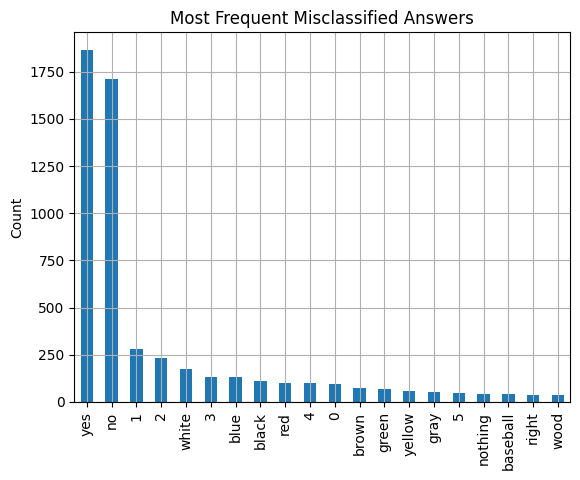

In [42]:
incorrect = [val_dataset.answers[i] for i in range(len(y_trues)) if y_trues[i] != y_preds[i]]
err_counts = collections.Counter(incorrect)
pd.Series(err_counts).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Most Frequent Misclassified Answers")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid()
plt.show()

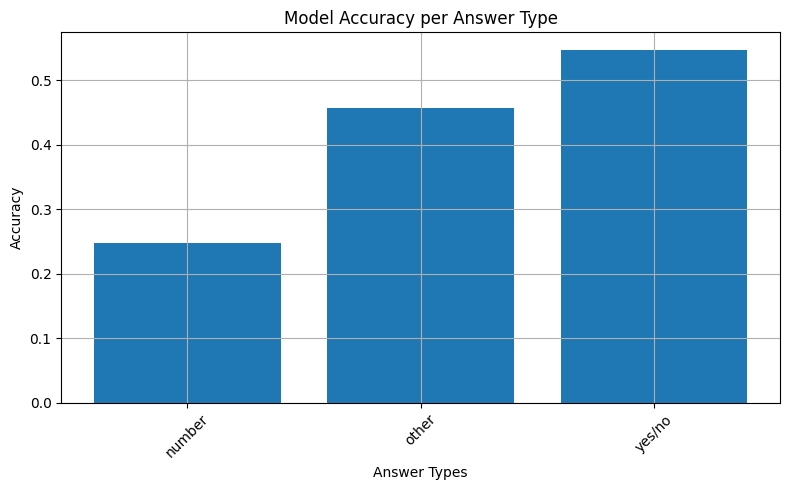

In [ ]:
model_acc = {}

for ans_type in np.unique(train_df['answer_type']):
    # filter validation data for the specific answer type
    val_df_filtered = val_df[val_df['answer_type'] == ans_type]

    # Create the validation dataset for this answer type
    val_dataset_filtered = CustomDatasetModel(
        val_df_filtered, 
        sbert_model,
        xception_featurizer,
        IMG_TARGET_SIZE, 
        ohe
    )

    # create the dataloader for the subset
    val_dataloader_filtered = CustomDataLoader(
        val_dataset_filtered, 
        batch_size=BATCH_SIZE, 
        shuffle_every_epoch=False
    )

    # Evaluate the model on this subset
    _, acc = model.evaluate(val_dataloader_filtered, verbose=0)

    # Store accuracy
    model_acc[ans_type] = acc

# plot Accuracy per Answer Type
plt.figure(figsize=(8,5))

plt.grid()
plt.title("Model Accuracy per Answer Type")
ans_types = np.unique(train_df['answer_type'])

plt.xlabel("Answer Types")
plt.ylabel("Accuracy")

# Collect accuracy values in order of answer types
acc_values = [model_acc[typ] for typ in ans_types]

plt.bar(ans_types, acc_values)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Evaluation Againt GQA-OOD

- Measures accuracy on ood_testdev_tail.json, ood_testdev_head.json, and ood_testdev_all.json.

- Prints out the accuracy numbers and detailed results.

In [ ]:
# Load testdev questions JSON
with open('Datasets/GQA/GQA-OOD/data/ood_testdev_all.json', 'r') as f:
    testdev_data = json.load(f)

# Convert to DataFrame for processing
records = []
for q_id, content in testdev_data.items():
    records.append({
        'question_id': q_id,
        'question': content['question'],
        'image_id': content['imageId']
    })

gqa_ood_testdev_df = pd.DataFrame(records)

# construct image paths
img_dir = "Datasets/GQA/Images/images"

gqa_ood_testdev_df['image_path'] = gqa_ood_testdev_df['image_id'].apply(lambda x: os.path.join(img_dir, f"{x}.jpg"))

gqa_ood_testdev_df.head()

,question_id,question,image_id,image_path
0,201030415,What kind of furniture is brown?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
1,201030459,What is the name of the piece of furniture tha...,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
2,201030460,What kind of furniture is in front of the wall?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
3,201030469,Which kind of furniture is the wall behind of?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
4,201030507,Does the shirt seem to be sleeveless or long s...,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg


In [41]:
gqa_ood_testdev_df.shape

(2796, 4)

In [ ]:
from tqdm import tqdm

def produce_answer(X):
    """
    Produce the answer for a question asked about an image using Model-1.
    
    Parameters:
    -----------
    X: pandas.DataFrame
        DataFrame containing 'image_path' and 'question' columns. 
        It can have a single row or multiple rows.
    
    Returns:
    --------
    pred_df: pandas.DataFrame
        DataFrame containing 'image_path', 'question', and the predicted 'answer' by Model-1.
    """
    pred_df = X.copy()
    pred_ans = []

    for i in tqdm(range(len(X))):
        row = X.iloc[i]

        # encode the question using SBERT
        enc_question = encode_questions_sbert(sbert_model, row['question'])[0]

        # encode the image using Xception
        xception_features = encode_image_with_xception(
            xception_featurizer,
            row['image_path'],
            IMG_TARGET_SIZE
        )[0]

        # generate answer prediction
        y_pred_val = model.predict([
            np.asarray([enc_question]), 
            np.asarray([xception_features])
        ])

        # Convert prediction (one-hot output) back to the original answer
        y_pred_val_label = ohe.inverse_transform(
            tf.one_hot(
                tf.argmax(y_pred_val, axis=1), 
                depth=len(ohe.categories_[0])
            )
        )[0][0]

        pred_ans.append(y_pred_val_label)

    # add predicted answers to dataframe
    pred_df["pred_answer"] = pred_ans

    return pred_df

In [ ]:
predictions_df = produce_answer(gqa_ood_testdev_df)

predictions_df[['question_id', 'pred_answer']].head()

  0%|          | 0/2796 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 1/2796 [00:01<1:22:07,  1.76s/it]

1/1 [==============================] - 0s 14ms/step


  0%|          | 2/2796 [00:01<36:50,  1.26it/s]  

1/1 [==============================] - 0s 13ms/step


  0%|          | 3/2796 [00:01<22:19,  2.09it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 4/2796 [00:02<15:27,  3.01it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 5/2796 [00:02<11:42,  3.98it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 6/2796 [00:02<09:28,  4.91it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 7/2796 [00:02<08:01,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 8/2796 [00:02<07:02,  6.60it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 9/2796 [00:02<06:21,  7.31it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 10/2796 [00:02<05:56,  7.81it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 11/2796 [00:02<05:45,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 12/2796 [00:02<05:36,  8.27it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 13/2796 [00:03<05:24,  8.58it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 14/2796 [00:03<05:17,  8.76it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 15/2796 [00:03<05:11,  8.94it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 16/2796 [00:03<05:06,  9.07it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 17/2796 [00:03<05:13,  8.86it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 18/2796 [00:03<05:14,  8.84it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 19/2796 [00:03<05:15,  8.81it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 20/2796 [00:03<05:15,  8.79it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 21/2796 [00:03<05:12,  8.87it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 22/2796 [00:04<05:10,  8.94it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 23/2796 [00:04<05:09,  8.95it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 24/2796 [00:04<05:09,  8.95it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 25/2796 [00:04<05:07,  9.02it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 26/2796 [00:04<05:08,  8.98it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 27/2796 [00:04<05:10,  8.92it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 28/2796 [00:04<05:08,  8.99it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 29/2796 [00:04<05:06,  9.02it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 30/2796 [00:05<05:38,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 31/2796 [00:05<05:32,  8.32it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 32/2796 [00:05<05:25,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 33/2796 [00:05<05:20,  8.63it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 34/2796 [00:05<05:16,  8.72it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 35/2796 [00:05<05:14,  8.78it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 36/2796 [00:05<05:12,  8.83it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 37/2796 [00:05<05:14,  8.76it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 38/2796 [00:05<05:17,  8.69it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 39/2796 [00:06<05:12,  8.82it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 40/2796 [00:06<05:09,  8.92it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 41/2796 [00:06<05:09,  8.90it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 42/2796 [00:06<05:07,  8.95it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 43/2796 [00:06<05:09,  8.90it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 44/2796 [00:06<05:08,  8.92it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 45/2796 [00:06<05:17,  8.67it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 46/2796 [00:06<05:13,  8.78it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 47/2796 [00:06<05:19,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 48/2796 [00:07<05:21,  8.55it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 49/2796 [00:07<05:30,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 50/2796 [00:07<05:35,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 51/2796 [00:07<05:33,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 52/2796 [00:07<05:39,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 53/2796 [00:07<05:47,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 54/2796 [00:07<05:42,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 55/2796 [00:07<05:45,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 56/2796 [00:08<05:48,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 57/2796 [00:08<05:50,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 58/2796 [00:08<05:41,  8.01it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 59/2796 [00:08<05:48,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 60/2796 [00:08<05:41,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 61/2796 [00:08<05:40,  8.03it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 62/2796 [00:08<05:50,  7.80it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 63/2796 [00:08<05:51,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 64/2796 [00:09<05:46,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 65/2796 [00:09<05:39,  8.05it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 66/2796 [00:09<05:56,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 67/2796 [00:09<06:05,  7.48it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 68/2796 [00:09<06:08,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 69/2796 [00:09<05:53,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 70/2796 [00:09<05:41,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 71/2796 [00:09<05:33,  8.16it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 72/2796 [00:10<05:25,  8.36it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 73/2796 [00:10<05:24,  8.39it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 74/2796 [00:10<05:17,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 75/2796 [00:10<05:16,  8.60it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 76/2796 [00:10<05:22,  8.43it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 77/2796 [00:10<05:16,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 78/2796 [00:10<05:13,  8.68it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 79/2796 [00:10<05:08,  8.81it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 80/2796 [00:10<05:06,  8.86it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 81/2796 [00:11<05:06,  8.85it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 82/2796 [00:11<05:11,  8.71it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 83/2796 [00:11<05:09,  8.76it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 84/2796 [00:11<05:07,  8.82it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 85/2796 [00:11<05:29,  8.23it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 86/2796 [00:11<05:42,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 87/2796 [00:11<05:36,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 88/2796 [00:11<05:39,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 89/2796 [00:12<05:39,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 90/2796 [00:12<05:47,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 91/2796 [00:12<06:40,  6.75it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 92/2796 [00:12<06:16,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 93/2796 [00:12<05:58,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 94/2796 [00:12<05:41,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 95/2796 [00:12<05:46,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 96/2796 [00:13<05:35,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 97/2796 [00:13<05:29,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 98/2796 [00:13<05:20,  8.42it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 99/2796 [00:13<05:15,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 100/2796 [00:13<05:12,  8.62it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 101/2796 [00:13<05:07,  8.76it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 102/2796 [00:13<05:10,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 103/2796 [00:13<05:07,  8.75it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▎         | 104/2796 [00:13<05:06,  8.77it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 105/2796 [00:14<05:03,  8.86it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 106/2796 [00:14<05:04,  8.83it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 107/2796 [00:14<05:14,  8.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 108/2796 [00:14<05:22,  8.35it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 109/2796 [00:14<05:30,  8.13it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 110/2796 [00:14<05:25,  8.25it/s]

1/1 [==============================] - 0s 170ms/step


  4%|▍         | 111/2796 [00:14<07:30,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 112/2796 [00:15<06:47,  6.58it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 113/2796 [00:15<06:19,  7.07it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 114/2796 [00:15<06:08,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 115/2796 [00:15<05:57,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 116/2796 [00:15<05:54,  7.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 117/2796 [00:15<05:40,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 118/2796 [00:15<05:29,  8.13it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 119/2796 [00:15<05:21,  8.33it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 120/2796 [00:16<05:16,  8.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 121/2796 [00:16<05:15,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 122/2796 [00:16<05:15,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 123/2796 [00:16<05:15,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 124/2796 [00:16<05:09,  8.63it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 125/2796 [00:16<05:11,  8.58it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 126/2796 [00:16<05:09,  8.63it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 127/2796 [00:16<05:09,  8.62it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 128/2796 [00:16<05:15,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 129/2796 [00:17<05:17,  8.41it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 130/2796 [00:17<05:11,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 131/2796 [00:17<05:10,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 132/2796 [00:17<05:04,  8.75it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 133/2796 [00:17<05:06,  8.69it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 134/2796 [00:17<05:11,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 135/2796 [00:17<05:10,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 136/2796 [00:17<05:08,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 137/2796 [00:17<05:02,  8.79it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 138/2796 [00:18<05:05,  8.71it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 139/2796 [00:18<06:22,  6.95it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 140/2796 [00:18<06:05,  7.26it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 141/2796 [00:18<05:48,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 142/2796 [00:18<05:37,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 143/2796 [00:18<05:28,  8.09it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 144/2796 [00:18<05:20,  8.26it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 145/2796 [00:19<05:21,  8.24it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 146/2796 [00:19<05:18,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 147/2796 [00:19<05:19,  8.29it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 148/2796 [00:19<05:23,  8.20it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 149/2796 [00:19<05:30,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 150/2796 [00:19<06:19,  6.96it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 151/2796 [00:19<06:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 152/2796 [00:19<05:44,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 153/2796 [00:20<05:36,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 154/2796 [00:20<05:33,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 155/2796 [00:20<05:25,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 156/2796 [00:20<05:20,  8.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 157/2796 [00:20<05:17,  8.31it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 158/2796 [00:20<05:14,  8.38it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 159/2796 [00:20<05:09,  8.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 160/2796 [00:20<05:09,  8.53it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 161/2796 [00:20<05:06,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 162/2796 [00:21<05:04,  8.64it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 163/2796 [00:21<05:09,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 164/2796 [00:21<05:09,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 165/2796 [00:21<05:18,  8.26it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 166/2796 [00:21<05:17,  8.28it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 167/2796 [00:21<05:34,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 168/2796 [00:21<05:30,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 169/2796 [00:22<05:56,  7.38it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 170/2796 [00:22<06:31,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 171/2796 [00:22<06:09,  7.10it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 172/2796 [00:22<05:57,  7.34it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 173/2796 [00:22<05:43,  7.64it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 174/2796 [00:22<05:42,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 175/2796 [00:22<05:39,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 176/2796 [00:22<05:30,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 177/2796 [00:23<05:29,  7.95it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 178/2796 [00:23<05:31,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 179/2796 [00:23<05:27,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 180/2796 [00:23<05:17,  8.24it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 181/2796 [00:23<05:15,  8.30it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 182/2796 [00:23<05:26,  8.01it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 183/2796 [00:23<05:14,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 184/2796 [00:23<05:09,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 185/2796 [00:24<05:02,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 186/2796 [00:24<05:18,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 187/2796 [00:24<05:28,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 188/2796 [00:24<05:22,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 189/2796 [00:24<05:18,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 190/2796 [00:24<05:31,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 191/2796 [00:24<05:28,  7.92it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 192/2796 [00:24<05:23,  8.05it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 193/2796 [00:25<05:29,  7.89it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 194/2796 [00:25<05:22,  8.07it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 195/2796 [00:25<05:28,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 196/2796 [00:25<05:24,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 197/2796 [00:25<05:19,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 198/2796 [00:25<05:20,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 199/2796 [00:25<05:17,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 200/2796 [00:25<05:22,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 201/2796 [00:26<05:26,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 202/2796 [00:26<05:26,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 203/2796 [00:26<05:29,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 204/2796 [00:26<05:24,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 205/2796 [00:26<05:21,  8.05it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 206/2796 [00:26<05:27,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 207/2796 [00:26<05:34,  7.74it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 208/2796 [00:26<05:34,  7.75it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 209/2796 [00:27<05:37,  7.65it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 210/2796 [00:27<05:36,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 211/2796 [00:27<05:30,  7.82it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 212/2796 [00:27<05:31,  7.79it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 213/2796 [00:27<05:25,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 214/2796 [00:27<05:24,  7.97it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 215/2796 [00:27<05:33,  7.73it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 216/2796 [00:27<05:32,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 217/2796 [00:28<05:26,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 218/2796 [00:28<05:20,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 219/2796 [00:28<05:23,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 220/2796 [00:28<05:20,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 221/2796 [00:28<05:35,  7.66it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 222/2796 [00:28<05:27,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 223/2796 [00:28<05:29,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 224/2796 [00:28<05:22,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 225/2796 [00:29<05:17,  8.09it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 226/2796 [00:29<05:21,  8.00it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 227/2796 [00:29<05:22,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 228/2796 [00:29<05:21,  8.00it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 229/2796 [00:29<05:16,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 230/2796 [00:29<05:28,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 231/2796 [00:29<05:22,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 232/2796 [00:29<05:17,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 233/2796 [00:30<05:22,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 234/2796 [00:30<05:15,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 235/2796 [00:30<05:18,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 236/2796 [00:30<05:14,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 237/2796 [00:30<05:24,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 238/2796 [00:30<05:35,  7.63it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 239/2796 [00:30<05:32,  7.69it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 240/2796 [00:30<05:44,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 241/2796 [00:31<05:37,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 242/2796 [00:31<05:45,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 243/2796 [00:31<05:45,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 244/2796 [00:31<05:42,  7.46it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 245/2796 [00:31<05:32,  7.67it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 246/2796 [00:31<05:29,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 247/2796 [00:31<05:24,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 248/2796 [00:32<05:21,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 249/2796 [00:32<05:26,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 250/2796 [00:32<05:28,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 251/2796 [00:32<05:21,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 252/2796 [00:32<05:37,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 253/2796 [00:32<05:27,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 254/2796 [00:32<05:22,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 255/2796 [00:32<05:19,  7.94it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 256/2796 [00:33<05:23,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 257/2796 [00:33<05:17,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 258/2796 [00:33<05:12,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 259/2796 [00:33<05:17,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 260/2796 [00:33<05:20,  7.90it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 261/2796 [00:33<05:23,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 262/2796 [00:33<05:20,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 263/2796 [00:33<05:16,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 264/2796 [00:34<05:13,  8.09it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 265/2796 [00:34<05:09,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 266/2796 [00:34<05:19,  7.92it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 267/2796 [00:34<05:31,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 268/2796 [00:34<05:34,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 269/2796 [00:34<05:35,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 270/2796 [00:34<05:25,  7.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 271/2796 [00:34<05:46,  7.28it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 272/2796 [00:35<05:47,  7.25it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 273/2796 [00:35<06:57,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 274/2796 [00:35<06:16,  6.69it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 275/2796 [00:35<06:00,  7.00it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 276/2796 [00:35<05:39,  7.43it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 277/2796 [00:35<05:23,  7.79it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 278/2796 [00:35<05:14,  8.00it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 279/2796 [00:36<05:05,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 280/2796 [00:36<04:53,  8.58it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 281/2796 [00:36<04:44,  8.83it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 282/2796 [00:36<04:39,  8.98it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 283/2796 [00:36<04:40,  8.97it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 284/2796 [00:36<04:35,  9.11it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 285/2796 [00:36<04:33,  9.17it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 286/2796 [00:36<04:39,  8.99it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 287/2796 [00:36<04:34,  9.15it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 288/2796 [00:37<04:29,  9.30it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 289/2796 [00:37<04:27,  9.37it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 290/2796 [00:37<04:26,  9.39it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 291/2796 [00:37<04:32,  9.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 292/2796 [00:37<04:41,  8.89it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 293/2796 [00:37<04:48,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 294/2796 [00:37<04:51,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 295/2796 [00:37<04:48,  8.68it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 296/2796 [00:37<04:57,  8.40it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 297/2796 [00:38<05:12,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 298/2796 [00:38<05:11,  8.03it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 299/2796 [00:38<05:20,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 300/2796 [00:38<05:17,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 301/2796 [00:38<05:09,  8.06it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 302/2796 [00:38<05:02,  8.25it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 303/2796 [00:38<05:05,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 304/2796 [00:38<05:02,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 305/2796 [00:39<04:59,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 306/2796 [00:39<04:56,  8.39it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 307/2796 [00:39<04:59,  8.30it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 308/2796 [00:39<04:55,  8.41it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 309/2796 [00:39<04:55,  8.41it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 310/2796 [00:39<04:53,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 311/2796 [00:39<04:52,  8.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 312/2796 [00:39<04:51,  8.51it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 313/2796 [00:40<05:01,  8.24it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 314/2796 [00:40<04:55,  8.40it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 315/2796 [00:40<05:03,  8.16it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 316/2796 [00:40<05:00,  8.25it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 317/2796 [00:40<05:20,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 318/2796 [00:40<05:17,  7.82it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 319/2796 [00:40<05:15,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 320/2796 [00:40<05:08,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 321/2796 [00:41<04:59,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 322/2796 [00:41<05:03,  8.15it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 323/2796 [00:41<05:11,  7.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 324/2796 [00:41<05:11,  7.93it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 325/2796 [00:41<05:14,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 326/2796 [00:41<05:09,  7.99it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 327/2796 [00:41<05:35,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 328/2796 [00:41<05:28,  7.52it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 329/2796 [00:42<05:14,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 330/2796 [00:42<05:04,  8.09it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 331/2796 [00:42<05:00,  8.21it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 332/2796 [00:42<04:55,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 333/2796 [00:42<04:58,  8.25it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 334/2796 [00:42<04:51,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 335/2796 [00:42<04:54,  8.36it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 336/2796 [00:42<04:49,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 337/2796 [00:42<04:50,  8.48it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 338/2796 [00:43<04:45,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 339/2796 [00:43<04:44,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 340/2796 [00:43<04:43,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 341/2796 [00:43<04:39,  8.78it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 342/2796 [00:43<04:40,  8.75it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 343/2796 [00:43<04:41,  8.72it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 344/2796 [00:43<04:48,  8.50it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 345/2796 [00:43<05:10,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 346/2796 [00:44<05:16,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 347/2796 [00:44<05:06,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 348/2796 [00:44<04:59,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 349/2796 [00:44<04:50,  8.42it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 350/2796 [00:44<04:44,  8.60it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 351/2796 [00:44<04:47,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 352/2796 [00:44<04:44,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 353/2796 [00:44<04:43,  8.60it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 354/2796 [00:44<04:42,  8.64it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 355/2796 [00:45<04:42,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 356/2796 [00:45<04:45,  8.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 357/2796 [00:45<04:44,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 358/2796 [00:45<04:41,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 359/2796 [00:45<04:39,  8.71it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 360/2796 [00:45<04:42,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 361/2796 [00:45<04:45,  8.52it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 362/2796 [00:45<04:47,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 363/2796 [00:46<04:51,  8.36it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 364/2796 [00:46<04:58,  8.15it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 365/2796 [00:46<04:51,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 366/2796 [00:46<04:46,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 367/2796 [00:46<04:42,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 368/2796 [00:46<04:39,  8.69it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 369/2796 [00:46<04:42,  8.61it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 370/2796 [00:46<04:41,  8.63it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 371/2796 [00:46<04:47,  8.43it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 372/2796 [00:47<04:47,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 373/2796 [00:47<04:41,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 374/2796 [00:47<04:39,  8.68it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 375/2796 [00:47<04:36,  8.75it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 376/2796 [00:47<04:36,  8.74it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 377/2796 [00:47<04:36,  8.75it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 378/2796 [00:47<04:35,  8.77it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 379/2796 [00:47<04:39,  8.65it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 380/2796 [00:48<04:49,  8.34it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 381/2796 [00:48<05:02,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 382/2796 [00:48<05:59,  6.71it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 383/2796 [00:48<05:36,  7.17it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 384/2796 [00:48<05:24,  7.44it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 385/2796 [00:48<05:10,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 386/2796 [00:48<04:58,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 387/2796 [00:48<04:55,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 388/2796 [00:49<05:00,  8.02it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 389/2796 [00:49<04:57,  8.08it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 390/2796 [00:49<04:55,  8.15it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 391/2796 [00:49<04:50,  8.27it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 392/2796 [00:49<05:07,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 393/2796 [00:49<04:58,  8.06it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 394/2796 [00:49<04:50,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 395/2796 [00:49<04:47,  8.34it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 396/2796 [00:50<04:47,  8.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 397/2796 [00:50<04:49,  8.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 398/2796 [00:50<04:54,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 399/2796 [00:50<04:50,  8.25it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 400/2796 [00:50<04:49,  8.28it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 401/2796 [00:50<04:46,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 402/2796 [00:50<04:41,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 403/2796 [00:50<04:44,  8.41it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 404/2796 [00:51<04:43,  8.43it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 405/2796 [00:51<04:43,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 406/2796 [00:51<04:41,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 407/2796 [00:51<04:42,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 408/2796 [00:51<04:39,  8.54it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 409/2796 [00:51<04:38,  8.57it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 410/2796 [00:51<04:43,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 411/2796 [00:51<04:43,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 412/2796 [00:51<04:41,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 413/2796 [00:52<04:49,  8.23it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 414/2796 [00:52<04:55,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 415/2796 [00:52<04:56,  8.02it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 416/2796 [00:52<05:05,  7.80it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 417/2796 [00:52<05:06,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 418/2796 [00:52<05:07,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 419/2796 [00:52<04:59,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 420/2796 [00:52<04:59,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 421/2796 [00:53<04:53,  8.10it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 422/2796 [00:53<04:47,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 423/2796 [00:53<04:46,  8.27it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 424/2796 [00:53<04:44,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 425/2796 [00:53<04:47,  8.23it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 426/2796 [00:53<04:41,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 427/2796 [00:53<04:39,  8.47it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 428/2796 [00:53<04:37,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 429/2796 [00:54<04:39,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 430/2796 [00:54<04:38,  8.50it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 431/2796 [00:54<04:37,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 432/2796 [00:54<04:39,  8.44it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 433/2796 [00:54<04:39,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 434/2796 [00:54<04:50,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 435/2796 [00:54<04:51,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 436/2796 [00:54<04:52,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 437/2796 [00:55<04:49,  8.16it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 438/2796 [00:55<05:03,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 439/2796 [00:55<04:55,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 440/2796 [00:55<04:51,  8.09it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 441/2796 [00:55<04:45,  8.26it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 442/2796 [00:55<04:38,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 443/2796 [00:55<04:44,  8.28it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 444/2796 [00:55<04:40,  8.38it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 445/2796 [00:56<04:38,  8.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 446/2796 [00:56<04:44,  8.26it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 447/2796 [00:56<04:41,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 448/2796 [00:56<04:40,  8.38it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 449/2796 [00:56<04:38,  8.44it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 450/2796 [00:56<04:36,  8.49it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 451/2796 [00:56<04:36,  8.48it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 452/2796 [00:56<04:37,  8.44it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 453/2796 [00:56<04:45,  8.21it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 454/2796 [00:57<04:52,  8.01it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 455/2796 [00:57<04:59,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 456/2796 [00:57<05:03,  7.72it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 457/2796 [00:57<04:54,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 458/2796 [00:57<04:47,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 459/2796 [00:57<04:45,  8.18it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 460/2796 [00:57<04:40,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 461/2796 [00:57<04:41,  8.29it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 462/2796 [00:58<04:40,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 463/2796 [00:58<04:46,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 464/2796 [00:58<04:45,  8.17it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 465/2796 [00:58<04:45,  8.15it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 466/2796 [00:58<04:37,  8.40it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 467/2796 [00:58<04:37,  8.40it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 468/2796 [00:58<04:31,  8.56it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 469/2796 [00:58<04:33,  8.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 470/2796 [00:59<04:31,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 471/2796 [00:59<04:28,  8.65it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 472/2796 [00:59<04:38,  8.33it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 473/2796 [00:59<04:54,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 474/2796 [00:59<04:49,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 475/2796 [00:59<04:54,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 476/2796 [00:59<04:54,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 477/2796 [00:59<04:51,  7.97it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 478/2796 [01:00<04:49,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 479/2796 [01:00<04:53,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 480/2796 [01:00<05:04,  7.62it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 481/2796 [01:00<04:55,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 482/2796 [01:00<04:48,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 483/2796 [01:00<04:46,  8.06it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 484/2796 [01:00<04:53,  7.87it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 485/2796 [01:00<05:16,  7.30it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 486/2796 [01:01<05:00,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 487/2796 [01:01<04:48,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 488/2796 [01:01<04:39,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 489/2796 [01:01<04:33,  8.43it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 490/2796 [01:01<04:34,  8.41it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 491/2796 [01:01<04:36,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 492/2796 [01:01<04:33,  8.41it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 493/2796 [01:01<04:33,  8.41it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 494/2796 [01:02<04:30,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 495/2796 [01:02<04:30,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 496/2796 [01:02<04:35,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 497/2796 [01:02<04:34,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 498/2796 [01:02<04:29,  8.52it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 499/2796 [01:02<04:39,  8.22it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 500/2796 [01:02<04:39,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 501/2796 [01:02<04:38,  8.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 502/2796 [01:02<04:36,  8.28it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 503/2796 [01:03<04:43,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 504/2796 [01:03<04:49,  7.91it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 505/2796 [01:03<04:47,  7.96it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 506/2796 [01:03<04:54,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 507/2796 [01:03<04:55,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 508/2796 [01:03<05:01,  7.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 509/2796 [01:03<05:00,  7.62it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 510/2796 [01:04<04:49,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 511/2796 [01:04<04:44,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 512/2796 [01:04<04:48,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 513/2796 [01:04<04:44,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 514/2796 [01:04<04:47,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 515/2796 [01:04<04:46,  7.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 516/2796 [01:04<04:53,  7.78it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 517/2796 [01:04<04:56,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 518/2796 [01:05<05:10,  7.34it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 519/2796 [01:05<04:59,  7.60it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 520/2796 [01:05<04:49,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 521/2796 [01:05<04:46,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 522/2796 [01:05<04:47,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 523/2796 [01:05<04:38,  8.16it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 524/2796 [01:05<04:32,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 525/2796 [01:05<04:29,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 526/2796 [01:05<04:21,  8.67it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 527/2796 [01:06<04:17,  8.82it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 528/2796 [01:06<04:14,  8.90it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 529/2796 [01:06<04:13,  8.94it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 530/2796 [01:06<04:12,  8.97it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 531/2796 [01:06<04:16,  8.84it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 532/2796 [01:06<04:16,  8.84it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 533/2796 [01:06<04:25,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 534/2796 [01:06<04:22,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 535/2796 [01:07<04:19,  8.72it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 536/2796 [01:07<04:16,  8.82it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 537/2796 [01:07<04:20,  8.68it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 538/2796 [01:07<04:21,  8.64it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 539/2796 [01:07<04:28,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 540/2796 [01:07<04:33,  8.24it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 541/2796 [01:07<04:45,  7.89it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 542/2796 [01:07<04:52,  7.71it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 543/2796 [01:08<04:48,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 544/2796 [01:08<04:45,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 545/2796 [01:08<04:38,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 546/2796 [01:08<04:34,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 547/2796 [01:08<04:36,  8.15it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 548/2796 [01:08<04:44,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 549/2796 [01:08<04:40,  8.02it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 550/2796 [01:08<04:54,  7.63it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 551/2796 [01:09<04:53,  7.66it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 552/2796 [01:09<04:56,  7.57it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 553/2796 [01:09<04:57,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 554/2796 [01:09<04:51,  7.70it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 555/2796 [01:09<04:49,  7.74it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 556/2796 [01:09<04:49,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 557/2796 [01:09<04:41,  7.95it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 558/2796 [01:09<04:38,  8.05it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 559/2796 [01:10<04:35,  8.12it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 560/2796 [01:10<04:31,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 561/2796 [01:10<04:28,  8.32it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 562/2796 [01:10<04:21,  8.54it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 563/2796 [01:10<04:21,  8.53it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 564/2796 [01:10<04:24,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 565/2796 [01:10<04:23,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 566/2796 [01:10<04:18,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 567/2796 [01:10<04:20,  8.55it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 568/2796 [01:11<04:17,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 569/2796 [01:11<04:22,  8.47it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 570/2796 [01:11<04:17,  8.65it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 571/2796 [01:11<04:25,  8.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 572/2796 [01:11<04:22,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 573/2796 [01:11<04:25,  8.37it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 574/2796 [01:11<04:27,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 575/2796 [01:11<04:26,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 576/2796 [01:12<04:28,  8.28it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 577/2796 [01:12<04:25,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 578/2796 [01:12<04:36,  8.03it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 579/2796 [01:12<04:45,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 580/2796 [01:12<04:51,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 581/2796 [01:12<04:43,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 582/2796 [01:12<04:46,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 583/2796 [01:12<04:41,  7.87it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 584/2796 [01:13<04:39,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 585/2796 [01:13<04:30,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 586/2796 [01:13<04:25,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 587/2796 [01:13<04:24,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 588/2796 [01:13<04:18,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 589/2796 [01:13<04:17,  8.58it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 590/2796 [01:13<04:16,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 591/2796 [01:13<04:26,  8.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 592/2796 [01:14<04:22,  8.38it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 593/2796 [01:14<04:22,  8.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 594/2796 [01:14<04:20,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 595/2796 [01:14<04:18,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 596/2796 [01:14<04:18,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 597/2796 [01:14<04:19,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 598/2796 [01:14<04:15,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 599/2796 [01:14<04:14,  8.64it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 600/2796 [01:14<04:14,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 601/2796 [01:15<04:17,  8.52it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 602/2796 [01:15<04:26,  8.23it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 603/2796 [01:15<04:33,  8.02it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 604/2796 [01:15<04:31,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 605/2796 [01:15<04:44,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 606/2796 [01:15<04:35,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 607/2796 [01:15<04:31,  8.06it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 608/2796 [01:15<04:38,  7.86it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 609/2796 [01:16<04:32,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 610/2796 [01:16<04:37,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 611/2796 [01:16<04:34,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 612/2796 [01:16<04:28,  8.15it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 613/2796 [01:16<04:23,  8.30it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 614/2796 [01:16<04:20,  8.38it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 615/2796 [01:16<04:15,  8.53it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 616/2796 [01:16<04:14,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 617/2796 [01:17<04:15,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 618/2796 [01:17<04:12,  8.63it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 619/2796 [01:17<04:20,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 620/2796 [01:17<04:17,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 621/2796 [01:17<04:26,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 622/2796 [01:17<04:27,  8.14it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 623/2796 [01:17<04:35,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 624/2796 [01:17<04:37,  7.82it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 625/2796 [01:18<04:39,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 626/2796 [01:18<04:35,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 627/2796 [01:18<04:35,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 628/2796 [01:18<05:32,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 629/2796 [01:18<05:20,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 630/2796 [01:18<05:10,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 631/2796 [01:18<04:56,  7.29it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 632/2796 [01:19<04:58,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 633/2796 [01:19<04:51,  7.43it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 634/2796 [01:19<04:41,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 635/2796 [01:19<04:53,  7.36it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 636/2796 [01:19<04:57,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 637/2796 [01:19<05:00,  7.19it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 638/2796 [01:19<04:50,  7.42it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 639/2796 [01:19<04:47,  7.51it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 640/2796 [01:20<04:42,  7.64it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 641/2796 [01:20<04:34,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 642/2796 [01:20<04:32,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 643/2796 [01:20<04:31,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 644/2796 [01:20<04:26,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 645/2796 [01:20<04:22,  8.20it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 646/2796 [01:20<04:17,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 647/2796 [01:20<04:17,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 648/2796 [01:21<04:15,  8.41it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 649/2796 [01:21<04:14,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 650/2796 [01:21<04:13,  8.45it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 651/2796 [01:21<04:12,  8.49it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 652/2796 [01:21<04:13,  8.45it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 653/2796 [01:21<04:12,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 654/2796 [01:21<04:13,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 655/2796 [01:21<04:11,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 656/2796 [01:21<04:09,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 657/2796 [01:22<04:09,  8.56it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 658/2796 [01:22<04:17,  8.31it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 659/2796 [01:22<04:39,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 660/2796 [01:22<04:39,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 661/2796 [01:22<04:34,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 662/2796 [01:22<04:33,  7.80it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 663/2796 [01:22<04:42,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 664/2796 [01:23<04:45,  7.47it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 665/2796 [01:23<04:40,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 666/2796 [01:23<04:31,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 667/2796 [01:23<04:28,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 668/2796 [01:23<04:22,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 669/2796 [01:23<04:15,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 670/2796 [01:23<04:09,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 671/2796 [01:23<04:07,  8.60it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 672/2796 [01:23<04:04,  8.70it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 673/2796 [01:24<04:05,  8.64it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 674/2796 [01:24<04:03,  8.70it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 675/2796 [01:24<04:10,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 676/2796 [01:24<04:06,  8.61it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 677/2796 [01:24<04:13,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 678/2796 [01:24<04:09,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 679/2796 [01:24<04:08,  8.51it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 680/2796 [01:24<04:15,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 681/2796 [01:25<04:21,  8.10it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 682/2796 [01:25<04:26,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 683/2796 [01:25<04:29,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 684/2796 [01:25<04:31,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 685/2796 [01:25<04:39,  7.56it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 686/2796 [01:25<04:30,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 687/2796 [01:25<04:27,  7.88it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 688/2796 [01:25<04:35,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 689/2796 [01:26<04:28,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 690/2796 [01:26<04:27,  7.87it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 691/2796 [01:26<04:32,  7.74it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 692/2796 [01:26<04:36,  7.62it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 693/2796 [01:26<04:30,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 694/2796 [01:26<04:31,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 695/2796 [01:26<04:36,  7.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 696/2796 [01:27<04:43,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 697/2796 [01:27<04:37,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 698/2796 [01:27<04:33,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 699/2796 [01:27<04:30,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 700/2796 [01:27<04:35,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 701/2796 [01:27<04:30,  7.74it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 702/2796 [01:27<04:37,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 703/2796 [01:27<04:38,  7.52it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 704/2796 [01:28<04:30,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 705/2796 [01:28<04:21,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 706/2796 [01:28<04:15,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 707/2796 [01:28<04:13,  8.23it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 708/2796 [01:28<04:08,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 709/2796 [01:28<04:05,  8.51it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 710/2796 [01:28<04:06,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 711/2796 [01:28<04:03,  8.55it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 712/2796 [01:28<04:03,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 713/2796 [01:29<04:04,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 714/2796 [01:29<04:02,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 715/2796 [01:29<04:01,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 716/2796 [01:29<04:04,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 717/2796 [01:29<04:01,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 718/2796 [01:29<04:00,  8.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 719/2796 [01:29<04:00,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 720/2796 [01:29<04:05,  8.44it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 721/2796 [01:30<04:12,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 722/2796 [01:30<04:14,  8.17it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 723/2796 [01:30<04:26,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 724/2796 [01:30<04:28,  7.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 725/2796 [01:30<04:30,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 726/2796 [01:30<04:23,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 727/2796 [01:30<04:20,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 728/2796 [01:30<04:18,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 729/2796 [01:31<04:19,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 730/2796 [01:31<04:18,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 731/2796 [01:31<04:17,  8.03it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 732/2796 [01:31<04:21,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 733/2796 [01:31<04:23,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 734/2796 [01:31<04:24,  7.80it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 735/2796 [01:31<04:22,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 736/2796 [01:31<04:20,  7.91it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██▋       | 737/2796 [01:32<04:19,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 738/2796 [01:32<04:25,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 739/2796 [01:32<04:26,  7.72it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 740/2796 [01:32<04:30,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 741/2796 [01:32<04:28,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 742/2796 [01:32<04:24,  7.76it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 743/2796 [01:32<04:27,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 744/2796 [01:33<04:30,  7.60it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 745/2796 [01:33<04:35,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 746/2796 [01:33<04:26,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 747/2796 [01:33<04:33,  7.49it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 748/2796 [01:33<04:35,  7.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 749/2796 [01:33<04:35,  7.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 750/2796 [01:33<04:32,  7.51it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 751/2796 [01:33<04:23,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 752/2796 [01:34<04:14,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 753/2796 [01:34<04:10,  8.16it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 754/2796 [01:34<04:02,  8.42it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 755/2796 [01:34<03:59,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 756/2796 [01:34<03:59,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 757/2796 [01:34<04:00,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 758/2796 [01:34<03:58,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 759/2796 [01:34<04:00,  8.48it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 760/2796 [01:35<04:19,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 761/2796 [01:35<04:11,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 762/2796 [01:35<04:02,  8.40it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 763/2796 [01:35<04:02,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 764/2796 [01:35<03:59,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 765/2796 [01:35<03:59,  8.47it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 766/2796 [01:35<04:02,  8.37it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 767/2796 [01:35<04:07,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 768/2796 [01:35<04:09,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 769/2796 [01:36<04:08,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 770/2796 [01:36<04:11,  8.06it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 771/2796 [01:36<04:12,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 772/2796 [01:36<04:26,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 773/2796 [01:36<04:21,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 774/2796 [01:36<04:17,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 775/2796 [01:36<04:22,  7.70it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 776/2796 [01:36<04:15,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 777/2796 [01:37<04:17,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 778/2796 [01:37<04:19,  7.79it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 779/2796 [01:37<04:20,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 780/2796 [01:37<04:17,  7.84it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 781/2796 [01:37<04:15,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 782/2796 [01:37<04:11,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 783/2796 [01:37<04:12,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 784/2796 [01:38<04:14,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 785/2796 [01:38<04:18,  7.77it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 786/2796 [01:38<04:18,  7.78it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 787/2796 [01:38<04:10,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 788/2796 [01:38<04:10,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 789/2796 [01:38<04:06,  8.14it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 790/2796 [01:38<03:59,  8.37it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 791/2796 [01:38<04:05,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 792/2796 [01:38<04:05,  8.16it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 793/2796 [01:39<03:59,  8.37it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 794/2796 [01:39<03:54,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 795/2796 [01:39<03:54,  8.52it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 796/2796 [01:39<03:58,  8.37it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 797/2796 [01:39<04:00,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 798/2796 [01:39<04:02,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 799/2796 [01:39<03:59,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 800/2796 [01:39<03:59,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 801/2796 [01:40<03:53,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 802/2796 [01:40<03:54,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 803/2796 [01:40<03:59,  8.33it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 804/2796 [01:40<04:08,  8.02it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 805/2796 [01:40<04:15,  7.79it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 806/2796 [01:40<04:12,  7.88it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 807/2796 [01:40<04:19,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 808/2796 [01:40<04:15,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 809/2796 [01:41<04:10,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 810/2796 [01:41<04:04,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 811/2796 [01:41<04:10,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 812/2796 [01:41<04:06,  8.05it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 813/2796 [01:41<04:10,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 814/2796 [01:41<04:06,  8.03it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 815/2796 [01:41<04:17,  7.70it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 816/2796 [01:41<04:10,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 817/2796 [01:42<04:07,  7.99it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 818/2796 [01:42<04:16,  7.71it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 819/2796 [01:42<04:14,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 820/2796 [01:42<04:12,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 821/2796 [01:42<04:05,  8.05it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 822/2796 [01:42<04:06,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 823/2796 [01:42<04:05,  8.03it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 824/2796 [01:42<04:16,  7.70it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 825/2796 [01:43<04:12,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 826/2796 [01:43<04:12,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 827/2796 [01:43<04:14,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 828/2796 [01:43<04:10,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 829/2796 [01:43<04:05,  8.02it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 830/2796 [01:43<04:04,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 831/2796 [01:43<04:11,  7.81it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 832/2796 [01:43<04:01,  8.14it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 833/2796 [01:44<03:55,  8.33it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 834/2796 [01:44<03:49,  8.54it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 835/2796 [01:44<03:49,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 836/2796 [01:44<03:48,  8.58it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 837/2796 [01:44<03:47,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 838/2796 [01:44<03:48,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 839/2796 [01:44<03:50,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 840/2796 [01:44<03:46,  8.64it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 841/2796 [01:45<03:46,  8.63it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 842/2796 [01:45<03:46,  8.64it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 843/2796 [01:45<03:45,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 844/2796 [01:45<03:42,  8.77it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 845/2796 [01:45<03:41,  8.82it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 846/2796 [01:45<03:39,  8.88it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 847/2796 [01:45<03:41,  8.81it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 848/2796 [01:45<03:46,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 849/2796 [01:45<03:46,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 850/2796 [01:46<03:51,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 851/2796 [01:46<04:02,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 852/2796 [01:46<03:59,  8.12it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 853/2796 [01:46<04:00,  8.09it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 854/2796 [01:46<03:59,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 855/2796 [01:46<04:04,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 856/2796 [01:46<04:05,  7.89it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███       | 857/2796 [01:46<04:00,  8.06it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 858/2796 [01:47<04:03,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 859/2796 [01:47<03:58,  8.11it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 860/2796 [01:47<04:00,  8.05it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 861/2796 [01:47<04:07,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 862/2796 [01:47<04:01,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 863/2796 [01:47<04:07,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 864/2796 [01:47<04:02,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 865/2796 [01:47<04:01,  7.98it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███       | 866/2796 [01:48<03:58,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 867/2796 [01:48<04:05,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 868/2796 [01:48<04:05,  7.85it/s]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 869/2796 [01:48<04:51,  6.61it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 870/2796 [01:48<04:34,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 871/2796 [01:48<04:30,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 872/2796 [01:48<04:20,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 873/2796 [01:49<04:16,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 874/2796 [01:49<04:10,  7.66it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 875/2796 [01:49<04:14,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 876/2796 [01:49<04:07,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 877/2796 [01:49<04:04,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 878/2796 [01:49<04:04,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 879/2796 [01:49<04:00,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 880/2796 [01:49<03:58,  8.04it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 881/2796 [01:50<04:09,  7.68it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 882/2796 [01:50<04:06,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 883/2796 [01:50<04:05,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 884/2796 [01:50<04:01,  7.92it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 885/2796 [01:50<04:11,  7.60it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 886/2796 [01:50<04:07,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 887/2796 [01:50<04:03,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 888/2796 [01:50<03:56,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 889/2796 [01:51<03:52,  8.20it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 890/2796 [01:51<03:56,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 891/2796 [01:51<03:57,  8.03it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 892/2796 [01:51<03:51,  8.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 893/2796 [01:51<03:50,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 894/2796 [01:51<03:49,  8.28it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 895/2796 [01:51<03:47,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 896/2796 [01:51<03:49,  8.27it/s]

1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 897/2796 [01:52<03:51,  8.19it/s]

1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 898/2796 [01:52<03:47,  8.34it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 899/2796 [01:52<03:47,  8.33it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 900/2796 [01:52<03:54,  8.08it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 901/2796 [01:52<03:47,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 902/2796 [01:52<04:01,  7.83it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 903/2796 [01:52<04:00,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 904/2796 [01:52<04:00,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 905/2796 [01:53<03:55,  8.03it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 906/2796 [01:53<03:55,  8.03it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 907/2796 [01:53<04:00,  7.85it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 908/2796 [01:53<04:07,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 909/2796 [01:53<04:09,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 910/2796 [01:53<04:04,  7.72it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 911/2796 [01:53<04:12,  7.47it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 912/2796 [01:53<04:03,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 913/2796 [01:54<03:56,  7.95it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 914/2796 [01:54<03:55,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 915/2796 [01:54<03:52,  8.11it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 916/2796 [01:54<03:47,  8.26it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 917/2796 [01:54<03:46,  8.29it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 918/2796 [01:54<03:43,  8.39it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 919/2796 [01:54<03:39,  8.55it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 920/2796 [01:54<03:36,  8.68it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 921/2796 [01:55<03:37,  8.60it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 922/2796 [01:55<03:36,  8.65it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 923/2796 [01:55<03:38,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 924/2796 [01:55<03:35,  8.67it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 925/2796 [01:55<03:37,  8.59it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 926/2796 [01:55<03:38,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 927/2796 [01:55<03:39,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 928/2796 [01:55<03:41,  8.43it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 929/2796 [01:55<03:47,  8.20it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 930/2796 [01:56<03:50,  8.08it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 931/2796 [01:56<03:49,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 932/2796 [01:56<03:52,  8.01it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 933/2796 [01:56<03:57,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 934/2796 [01:56<04:01,  7.72it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 935/2796 [01:56<04:03,  7.65it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 936/2796 [01:56<03:59,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▎      | 937/2796 [01:56<03:56,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 938/2796 [01:57<03:51,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 939/2796 [01:57<03:57,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 940/2796 [01:57<03:55,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 941/2796 [01:57<03:57,  7.80it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▎      | 942/2796 [01:57<03:57,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 943/2796 [01:57<04:02,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 944/2796 [01:57<03:58,  7.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 945/2796 [01:58<04:01,  7.67it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 946/2796 [01:58<04:03,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 947/2796 [01:58<04:02,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 948/2796 [01:58<03:56,  7.81it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 949/2796 [01:58<04:07,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 950/2796 [01:58<04:07,  7.45it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 951/2796 [01:58<03:57,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 952/2796 [01:58<03:51,  7.96it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 953/2796 [01:59<03:48,  8.07it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 954/2796 [01:59<03:58,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 955/2796 [01:59<03:59,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 956/2796 [01:59<03:50,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 957/2796 [01:59<03:45,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 958/2796 [01:59<03:43,  8.22it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 959/2796 [01:59<03:47,  8.09it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 960/2796 [01:59<03:41,  8.30it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 961/2796 [02:00<03:39,  8.35it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 962/2796 [02:00<03:33,  8.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 963/2796 [02:00<03:38,  8.40it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 964/2796 [02:00<03:36,  8.47it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 965/2796 [02:00<03:35,  8.49it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 966/2796 [02:00<03:35,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 967/2796 [02:00<03:34,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 968/2796 [02:00<03:34,  8.51it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███▍      | 969/2796 [02:00<03:33,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 970/2796 [02:01<03:34,  8.50it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 971/2796 [02:01<03:42,  8.20it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 972/2796 [02:01<03:57,  7.67it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 973/2796 [02:01<03:54,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 974/2796 [02:01<03:54,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 975/2796 [02:01<03:54,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 976/2796 [02:01<03:49,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 977/2796 [02:01<03:45,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 978/2796 [02:02<03:46,  8.03it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 979/2796 [02:02<03:49,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 980/2796 [02:02<03:46,  8.01it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 981/2796 [02:02<03:47,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 982/2796 [02:02<03:52,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 983/2796 [02:02<03:47,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 984/2796 [02:02<03:43,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 985/2796 [02:02<03:41,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 986/2796 [02:03<03:42,  8.13it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 987/2796 [02:03<03:39,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 988/2796 [02:03<03:35,  8.38it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 989/2796 [02:03<03:32,  8.49it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███▌      | 990/2796 [02:03<03:31,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 991/2796 [02:03<03:31,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 992/2796 [02:03<03:31,  8.54it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 993/2796 [02:03<03:28,  8.66it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 994/2796 [02:04<03:28,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 995/2796 [02:04<03:27,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 996/2796 [02:04<03:29,  8.60it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 997/2796 [02:04<03:29,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 998/2796 [02:04<03:28,  8.61it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 999/2796 [02:04<03:27,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1000/2796 [02:04<03:26,  8.71it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1001/2796 [02:04<03:28,  8.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1002/2796 [02:04<03:40,  8.14it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1003/2796 [02:05<03:47,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1004/2796 [02:05<03:57,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1005/2796 [02:05<03:50,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1006/2796 [02:05<03:50,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1007/2796 [02:05<03:45,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1008/2796 [02:05<03:47,  7.85it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1009/2796 [02:05<03:50,  7.74it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1010/2796 [02:06<03:43,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1011/2796 [02:06<03:38,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1012/2796 [02:06<03:31,  8.43it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1013/2796 [02:06<03:33,  8.34it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1014/2796 [02:06<03:31,  8.43it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1015/2796 [02:06<03:33,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1016/2796 [02:06<03:35,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1017/2796 [02:06<03:29,  8.47it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1018/2796 [02:06<03:28,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1019/2796 [02:07<03:27,  8.58it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1020/2796 [02:07<03:26,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1021/2796 [02:07<03:26,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1022/2796 [02:07<03:25,  8.63it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1023/2796 [02:07<03:26,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1024/2796 [02:07<03:25,  8.64it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1025/2796 [02:07<03:32,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1026/2796 [02:07<03:35,  8.20it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1027/2796 [02:08<03:38,  8.08it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1028/2796 [02:08<03:45,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1029/2796 [02:08<03:42,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1030/2796 [02:08<03:44,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1031/2796 [02:08<03:45,  7.82it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1032/2796 [02:08<03:48,  7.73it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1033/2796 [02:08<03:39,  8.02it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1034/2796 [02:08<03:35,  8.18it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1035/2796 [02:09<03:33,  8.26it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1036/2796 [02:09<03:29,  8.40it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1037/2796 [02:09<03:29,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1038/2796 [02:09<03:26,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1039/2796 [02:09<03:23,  8.61it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1040/2796 [02:09<03:25,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1041/2796 [02:09<03:29,  8.39it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1042/2796 [02:09<03:28,  8.40it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1043/2796 [02:09<03:26,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1044/2796 [02:10<03:26,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1045/2796 [02:10<03:35,  8.14it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1046/2796 [02:10<03:30,  8.29it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1047/2796 [02:10<03:28,  8.41it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1048/2796 [02:10<03:36,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1049/2796 [02:10<03:46,  7.72it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1050/2796 [02:10<03:42,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1051/2796 [02:10<03:42,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1052/2796 [02:11<03:40,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1053/2796 [02:11<03:39,  7.93it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1054/2796 [02:11<03:43,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1055/2796 [02:11<03:42,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1056/2796 [02:11<03:44,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1057/2796 [02:11<03:40,  7.88it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1058/2796 [02:11<03:44,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1059/2796 [02:11<03:41,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1060/2796 [02:12<03:39,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1061/2796 [02:12<03:39,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1062/2796 [02:12<03:36,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1063/2796 [02:12<03:32,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1064/2796 [02:12<03:37,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1065/2796 [02:12<03:40,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1066/2796 [02:12<03:36,  7.99it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1067/2796 [02:13<03:45,  7.66it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1068/2796 [02:13<03:44,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1069/2796 [02:13<03:41,  7.80it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1070/2796 [02:13<03:45,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1071/2796 [02:13<03:42,  7.74it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1072/2796 [02:13<03:37,  7.93it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1073/2796 [02:13<03:29,  8.21it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1074/2796 [02:13<03:28,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1075/2796 [02:13<03:25,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1076/2796 [02:14<03:24,  8.41it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1077/2796 [02:14<03:21,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1078/2796 [02:14<03:18,  8.64it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1079/2796 [02:14<03:19,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1080/2796 [02:14<03:19,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1081/2796 [02:14<03:19,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1082/2796 [02:14<03:19,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1083/2796 [02:14<03:21,  8.52it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1084/2796 [02:15<03:19,  8.58it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1085/2796 [02:15<03:21,  8.49it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1086/2796 [02:15<03:25,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1087/2796 [02:15<03:20,  8.52it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1088/2796 [02:15<03:25,  8.30it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1089/2796 [02:15<03:28,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1090/2796 [02:15<03:37,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1091/2796 [02:15<03:39,  7.78it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1092/2796 [02:16<03:52,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1093/2796 [02:16<05:08,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1094/2796 [02:16<04:42,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1095/2796 [02:16<04:29,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1096/2796 [02:16<04:16,  6.63it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1097/2796 [02:16<04:04,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1098/2796 [02:17<03:56,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1099/2796 [02:17<03:53,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1100/2796 [02:17<03:43,  7.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1101/2796 [02:17<03:50,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1102/2796 [02:17<03:50,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1103/2796 [02:17<03:51,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1104/2796 [02:17<03:48,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1105/2796 [02:17<03:41,  7.65it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1106/2796 [02:18<03:35,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1107/2796 [02:18<03:42,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1108/2796 [02:18<03:41,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1109/2796 [02:18<03:44,  7.52it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1110/2796 [02:18<04:25,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1111/2796 [02:18<04:12,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1112/2796 [02:18<04:02,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1113/2796 [02:19<03:56,  7.10it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1114/2796 [02:19<03:52,  7.25it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1115/2796 [02:19<03:57,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 1116/2796 [02:19<04:01,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1117/2796 [02:19<03:58,  7.03it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1118/2796 [02:19<03:48,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1119/2796 [02:19<03:43,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1120/2796 [02:20<03:47,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1121/2796 [02:20<03:44,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1122/2796 [02:20<03:39,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1123/2796 [02:20<03:38,  7.65it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1124/2796 [02:20<03:37,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1125/2796 [02:20<03:39,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1126/2796 [02:20<03:36,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1127/2796 [02:20<03:32,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1128/2796 [02:21<03:32,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 1129/2796 [02:21<03:29,  7.95it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 1130/2796 [02:21<03:33,  7.82it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1131/2796 [02:21<03:34,  7.78it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1132/2796 [02:21<03:39,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1133/2796 [02:21<03:38,  7.61it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1134/2796 [02:21<03:41,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1135/2796 [02:21<03:37,  7.64it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1136/2796 [02:22<03:36,  7.67it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1137/2796 [02:22<03:37,  7.62it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 1138/2796 [02:22<03:39,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1139/2796 [02:22<03:43,  7.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1140/2796 [02:22<03:46,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1141/2796 [02:22<03:41,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1142/2796 [02:22<03:40,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1143/2796 [02:23<03:38,  7.58it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1144/2796 [02:23<03:43,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1145/2796 [02:23<03:37,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1146/2796 [02:23<03:31,  7.80it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1147/2796 [02:23<03:42,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1148/2796 [02:23<03:45,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1149/2796 [02:23<03:45,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1150/2796 [02:23<03:42,  7.41it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 1151/2796 [02:24<03:50,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1152/2796 [02:24<03:50,  7.14it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 1153/2796 [02:24<03:45,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1154/2796 [02:24<03:41,  7.40it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 1155/2796 [02:24<03:45,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1156/2796 [02:24<03:42,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1157/2796 [02:24<03:40,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1158/2796 [02:25<03:38,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1159/2796 [02:25<03:38,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1160/2796 [02:25<03:33,  7.67it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1161/2796 [02:25<03:28,  7.83it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1162/2796 [02:25<03:29,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1163/2796 [02:25<03:29,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1164/2796 [02:25<03:28,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1165/2796 [02:25<03:32,  7.67it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1166/2796 [02:26<03:36,  7.54it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1167/2796 [02:26<03:33,  7.63it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1168/2796 [02:26<03:40,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1169/2796 [02:26<03:31,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1170/2796 [02:26<03:26,  7.86it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1171/2796 [02:26<03:23,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1172/2796 [02:26<03:23,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1173/2796 [02:27<03:20,  8.10it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1174/2796 [02:27<03:18,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1175/2796 [02:27<03:25,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1176/2796 [02:27<03:26,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1177/2796 [02:27<03:35,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1178/2796 [02:27<03:28,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1179/2796 [02:27<03:26,  7.83it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1180/2796 [02:27<03:28,  7.76it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1181/2796 [02:28<03:31,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1182/2796 [02:28<03:32,  7.59it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1183/2796 [02:28<03:29,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1184/2796 [02:28<03:27,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1185/2796 [02:28<03:31,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1186/2796 [02:28<03:31,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1187/2796 [02:28<03:28,  7.73it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1188/2796 [02:28<03:26,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1189/2796 [02:29<03:36,  7.42it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1190/2796 [02:29<03:32,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1191/2796 [02:29<03:26,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1192/2796 [02:29<03:25,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1193/2796 [02:29<03:26,  7.77it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1194/2796 [02:29<03:25,  7.79it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1195/2796 [02:29<03:23,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1196/2796 [02:29<03:23,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1197/2796 [02:30<03:24,  7.84it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1198/2796 [02:30<03:19,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1199/2796 [02:30<03:21,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1200/2796 [02:30<03:17,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1201/2796 [02:30<03:16,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1202/2796 [02:30<03:14,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1203/2796 [02:30<03:19,  7.98it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1204/2796 [02:30<03:22,  7.88it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1205/2796 [02:31<03:23,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1206/2796 [02:31<03:20,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1207/2796 [02:31<03:19,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1208/2796 [02:31<03:25,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1209/2796 [02:31<03:25,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1210/2796 [02:31<03:23,  7.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1211/2796 [02:31<03:22,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1212/2796 [02:32<03:23,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1213/2796 [02:32<03:23,  7.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1214/2796 [02:32<03:23,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1215/2796 [02:32<03:21,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1216/2796 [02:32<03:17,  7.99it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1217/2796 [02:32<03:25,  7.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1218/2796 [02:32<03:25,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 1219/2796 [02:32<03:26,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1220/2796 [02:33<03:22,  7.78it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1221/2796 [02:33<03:30,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1222/2796 [02:33<03:24,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1223/2796 [02:33<03:23,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1224/2796 [02:33<03:24,  7.69it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1225/2796 [02:33<03:34,  7.34it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1226/2796 [02:33<03:36,  7.25it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1227/2796 [02:33<03:32,  7.37it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1228/2796 [02:34<03:34,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1229/2796 [02:34<03:30,  7.44it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1230/2796 [02:34<03:31,  7.39it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1231/2796 [02:34<03:30,  7.43it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1232/2796 [02:34<03:37,  7.18it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1233/2796 [02:34<03:28,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1234/2796 [02:34<03:30,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1235/2796 [02:35<03:40,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1236/2796 [02:35<03:32,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1237/2796 [02:35<03:25,  7.58it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1238/2796 [02:35<03:23,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1239/2796 [02:35<03:20,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1240/2796 [02:35<03:18,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1241/2796 [02:35<03:14,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1242/2796 [02:35<03:15,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1243/2796 [02:36<03:19,  7.77it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1244/2796 [02:36<03:24,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1245/2796 [02:36<03:21,  7.69it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1246/2796 [02:36<03:25,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1247/2796 [02:36<03:25,  7.53it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1248/2796 [02:36<03:23,  7.61it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1249/2796 [02:36<03:18,  7.80it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1250/2796 [02:37<03:24,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1251/2796 [02:37<03:24,  7.55it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1252/2796 [02:37<03:27,  7.45it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1253/2796 [02:37<03:33,  7.24it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1254/2796 [02:37<03:24,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1255/2796 [02:37<03:23,  7.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1256/2796 [02:37<03:23,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1257/2796 [02:37<03:20,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1258/2796 [02:38<03:16,  7.82it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1259/2796 [02:38<03:16,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1260/2796 [02:38<03:16,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1261/2796 [02:38<03:15,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1262/2796 [02:38<03:14,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1263/2796 [02:38<03:17,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1264/2796 [02:38<03:14,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1265/2796 [02:38<03:11,  7.98it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1266/2796 [02:39<03:11,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1267/2796 [02:39<03:15,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1268/2796 [02:39<03:12,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1269/2796 [02:39<03:11,  7.99it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1270/2796 [02:39<03:21,  7.58it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1271/2796 [02:39<03:17,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1272/2796 [02:39<03:13,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1273/2796 [02:39<03:11,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1274/2796 [02:40<03:06,  8.14it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1275/2796 [02:40<03:09,  8.04it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1276/2796 [02:40<03:13,  7.87it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1277/2796 [02:40<03:09,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1278/2796 [02:40<03:12,  7.88it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1279/2796 [02:40<03:09,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1280/2796 [02:40<03:10,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1281/2796 [02:40<03:12,  7.88it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1282/2796 [02:41<03:14,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1283/2796 [02:41<03:13,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1284/2796 [02:41<03:11,  7.90it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1285/2796 [02:41<03:07,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1286/2796 [02:41<03:09,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1287/2796 [02:41<03:14,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1288/2796 [02:41<03:15,  7.70it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1289/2796 [02:42<03:14,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1290/2796 [02:42<03:12,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1291/2796 [02:42<03:16,  7.67it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1292/2796 [02:42<03:12,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1293/2796 [02:42<03:20,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1294/2796 [02:42<03:21,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1295/2796 [02:42<03:11,  7.84it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▋     | 1296/2796 [02:42<03:05,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1297/2796 [02:43<03:00,  8.31it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▋     | 1298/2796 [02:43<03:08,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1299/2796 [02:43<03:05,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1300/2796 [02:43<02:59,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1301/2796 [02:43<02:56,  8.47it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1302/2796 [02:43<02:54,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1303/2796 [02:43<03:01,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1304/2796 [02:43<03:01,  8.20it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1305/2796 [02:43<02:57,  8.41it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1306/2796 [02:44<02:55,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1307/2796 [02:44<02:54,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1308/2796 [02:44<02:52,  8.62it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1309/2796 [02:44<02:55,  8.49it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1310/2796 [02:44<02:58,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1311/2796 [02:44<02:59,  8.25it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1312/2796 [02:44<03:02,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1313/2796 [02:44<03:02,  8.14it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1314/2796 [02:45<03:00,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1315/2796 [02:45<03:10,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1316/2796 [02:45<03:10,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1317/2796 [02:45<03:12,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1318/2796 [02:45<03:06,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1319/2796 [02:45<03:01,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1320/2796 [02:45<02:58,  8.25it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1321/2796 [02:45<02:58,  8.26it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1322/2796 [02:46<03:06,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1323/2796 [02:46<03:09,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1324/2796 [02:46<03:11,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1325/2796 [02:46<03:09,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1326/2796 [02:46<03:06,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1327/2796 [02:46<03:01,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1328/2796 [02:46<02:58,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1329/2796 [02:46<03:06,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1330/2796 [02:47<03:07,  7.84it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1331/2796 [02:47<03:06,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1332/2796 [02:47<03:09,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1333/2796 [02:47<03:08,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1334/2796 [02:47<03:05,  7.89it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1335/2796 [02:47<03:05,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1336/2796 [02:47<03:02,  7.98it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1337/2796 [02:47<02:58,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1338/2796 [02:48<03:01,  8.04it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1339/2796 [02:48<03:02,  7.98it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1340/2796 [02:48<03:08,  7.73it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1341/2796 [02:48<03:08,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1342/2796 [02:48<03:05,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1343/2796 [02:48<03:43,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1344/2796 [02:48<03:28,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1345/2796 [02:49<03:22,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1346/2796 [02:49<03:18,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1347/2796 [02:49<03:17,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1348/2796 [02:49<03:17,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1349/2796 [02:49<03:09,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1350/2796 [02:49<03:11,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1351/2796 [02:49<03:07,  7.70it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1352/2796 [02:50<03:13,  7.48it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1353/2796 [02:50<03:10,  7.58it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1354/2796 [02:50<03:05,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1355/2796 [02:50<03:02,  7.88it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1356/2796 [02:50<02:59,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1357/2796 [02:50<03:08,  7.64it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1358/2796 [02:50<03:03,  7.82it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1359/2796 [02:50<02:59,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1360/2796 [02:51<03:03,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1361/2796 [02:51<03:06,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1362/2796 [02:51<03:01,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1363/2796 [02:51<03:00,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1364/2796 [02:51<03:01,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1365/2796 [02:51<03:09,  7.55it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1366/2796 [02:51<03:08,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1367/2796 [02:51<03:07,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1368/2796 [02:52<03:03,  7.76it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1369/2796 [02:52<03:00,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1370/2796 [02:52<03:09,  7.51it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1371/2796 [02:52<03:07,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1372/2796 [02:52<03:04,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1373/2796 [02:52<03:02,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1374/2796 [02:52<03:09,  7.51it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1375/2796 [02:52<03:14,  7.29it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1376/2796 [02:53<03:07,  7.56it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1377/2796 [02:53<02:58,  7.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1378/2796 [02:53<02:54,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1379/2796 [02:53<02:52,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1380/2796 [02:53<02:47,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1381/2796 [02:53<02:44,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1382/2796 [02:53<02:43,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1383/2796 [02:53<02:43,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1384/2796 [02:54<02:43,  8.62it/s]

1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1385/2796 [02:54<02:42,  8.68it/s]

1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1386/2796 [02:54<02:40,  8.80it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 1387/2796 [02:54<02:42,  8.67it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1388/2796 [02:54<02:45,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 1389/2796 [02:54<02:52,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 1390/2796 [02:54<02:50,  8.25it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1391/2796 [02:54<02:47,  8.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1392/2796 [02:54<02:48,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 1393/2796 [02:55<02:55,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1394/2796 [02:55<03:03,  7.64it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1395/2796 [02:55<03:01,  7.73it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1396/2796 [02:55<03:06,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1397/2796 [02:55<03:01,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1398/2796 [02:55<02:57,  7.86it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1399/2796 [02:55<02:58,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1400/2796 [02:56<02:59,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1401/2796 [02:56<02:59,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1402/2796 [02:56<02:56,  7.90it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1403/2796 [02:56<02:59,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1404/2796 [02:56<02:55,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1405/2796 [02:56<03:02,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1406/2796 [02:56<02:58,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1407/2796 [02:56<02:55,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1408/2796 [02:57<02:54,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1409/2796 [02:57<02:51,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1410/2796 [02:57<02:52,  8.05it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1411/2796 [02:57<02:57,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1412/2796 [02:57<02:53,  7.98it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1413/2796 [02:57<02:53,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1414/2796 [02:57<02:53,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1415/2796 [02:57<02:57,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1416/2796 [02:58<02:54,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1417/2796 [02:58<02:52,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1418/2796 [02:58<02:55,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1419/2796 [02:58<02:55,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1420/2796 [02:58<02:53,  7.94it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1421/2796 [02:58<02:56,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1422/2796 [02:58<02:55,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1423/2796 [02:58<02:53,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1424/2796 [02:59<02:55,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1425/2796 [02:59<02:53,  7.89it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1426/2796 [02:59<02:58,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1427/2796 [02:59<02:59,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1428/2796 [02:59<03:00,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1429/2796 [02:59<02:55,  7.80it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1430/2796 [02:59<02:52,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1431/2796 [02:59<03:01,  7.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1432/2796 [03:00<02:56,  7.71it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1433/2796 [03:00<02:59,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1434/2796 [03:00<02:53,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1435/2796 [03:00<02:50,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1436/2796 [03:00<02:58,  7.63it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1437/2796 [03:00<02:58,  7.63it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1438/2796 [03:00<02:58,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1439/2796 [03:01<02:54,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1440/2796 [03:01<02:53,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1441/2796 [03:01<02:48,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1442/2796 [03:01<02:48,  8.02it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1443/2796 [03:01<02:54,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1444/2796 [03:01<02:57,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1445/2796 [03:01<02:59,  7.53it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1446/2796 [03:01<02:58,  7.58it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1447/2796 [03:02<02:53,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1448/2796 [03:02<02:55,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1449/2796 [03:02<02:51,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1450/2796 [03:02<02:47,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1451/2796 [03:02<02:53,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1452/2796 [03:02<02:53,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1453/2796 [03:02<02:53,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1454/2796 [03:02<02:51,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1455/2796 [03:03<02:51,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1456/2796 [03:03<02:47,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1457/2796 [03:03<02:51,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1458/2796 [03:03<02:46,  8.02it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1459/2796 [03:03<02:51,  7.79it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1460/2796 [03:03<02:50,  7.82it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1461/2796 [03:03<02:44,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1462/2796 [03:03<02:40,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1463/2796 [03:04<02:40,  8.29it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1464/2796 [03:04<02:37,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1465/2796 [03:04<02:35,  8.53it/s]

1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1466/2796 [03:04<02:35,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1467/2796 [03:04<02:34,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1468/2796 [03:04<02:33,  8.67it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1469/2796 [03:04<02:33,  8.64it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1470/2796 [03:04<02:32,  8.70it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1471/2796 [03:05<02:44,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1472/2796 [03:05<02:44,  8.03it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1473/2796 [03:05<02:41,  8.20it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1474/2796 [03:05<02:37,  8.41it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1475/2796 [03:05<02:37,  8.40it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1476/2796 [03:05<02:39,  8.28it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1477/2796 [03:05<02:49,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1478/2796 [03:05<02:57,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1479/2796 [03:06<02:51,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1480/2796 [03:06<02:50,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1481/2796 [03:06<02:47,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1482/2796 [03:06<02:48,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1483/2796 [03:06<02:46,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1484/2796 [03:06<02:47,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1485/2796 [03:06<02:52,  7.59it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1486/2796 [03:06<02:52,  7.58it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1487/2796 [03:07<02:47,  7.82it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1488/2796 [03:07<02:48,  7.76it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1489/2796 [03:07<02:49,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1490/2796 [03:07<02:45,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1491/2796 [03:07<02:50,  7.64it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1492/2796 [03:07<02:47,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1493/2796 [03:07<02:49,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1494/2796 [03:07<02:47,  7.75it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1495/2796 [03:08<02:50,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1496/2796 [03:08<02:47,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1497/2796 [03:08<02:47,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1498/2796 [03:08<02:46,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1499/2796 [03:08<02:50,  7.62it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1500/2796 [03:08<02:48,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1501/2796 [03:08<02:44,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1502/2796 [03:08<02:40,  8.06it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1503/2796 [03:09<02:42,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1504/2796 [03:09<02:39,  8.08it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1505/2796 [03:09<02:40,  8.05it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1506/2796 [03:09<02:44,  7.86it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1507/2796 [03:09<02:42,  7.95it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1508/2796 [03:09<02:43,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1509/2796 [03:09<02:41,  7.97it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1510/2796 [03:09<02:46,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1511/2796 [03:10<02:45,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1512/2796 [03:10<02:44,  7.82it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1513/2796 [03:10<02:40,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1514/2796 [03:10<02:39,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1515/2796 [03:10<02:37,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1516/2796 [03:10<02:35,  8.25it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1517/2796 [03:10<02:33,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1518/2796 [03:10<02:34,  8.29it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1519/2796 [03:11<02:30,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1520/2796 [03:11<02:26,  8.68it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1521/2796 [03:11<02:27,  8.64it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████▍    | 1522/2796 [03:11<02:24,  8.81it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1523/2796 [03:11<02:25,  8.73it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1524/2796 [03:11<02:25,  8.76it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1525/2796 [03:11<02:26,  8.69it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1526/2796 [03:11<02:25,  8.74it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1527/2796 [03:11<02:24,  8.78it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1528/2796 [03:12<02:25,  8.74it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1529/2796 [03:12<02:37,  8.02it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1530/2796 [03:12<02:35,  8.14it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1531/2796 [03:12<02:37,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1532/2796 [03:12<02:45,  7.63it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1533/2796 [03:12<02:41,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1534/2796 [03:12<02:38,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1535/2796 [03:12<02:36,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1536/2796 [03:13<02:40,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1537/2796 [03:13<02:41,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1538/2796 [03:13<02:37,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1539/2796 [03:13<02:36,  8.04it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1540/2796 [03:13<02:38,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1541/2796 [03:13<02:34,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1542/2796 [03:13<02:32,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1543/2796 [03:13<02:35,  8.06it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1544/2796 [03:14<02:30,  8.29it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 1545/2796 [03:14<02:28,  8.43it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 1546/2796 [03:14<02:25,  8.58it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1547/2796 [03:14<02:25,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1548/2796 [03:14<02:23,  8.72it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1549/2796 [03:14<02:23,  8.70it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1550/2796 [03:14<02:24,  8.64it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1551/2796 [03:14<02:27,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1552/2796 [03:15<02:25,  8.54it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1553/2796 [03:15<02:26,  8.51it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1554/2796 [03:15<02:26,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1555/2796 [03:15<02:24,  8.56it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1556/2796 [03:15<02:31,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1557/2796 [03:15<02:31,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1558/2796 [03:15<02:38,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1559/2796 [03:15<02:36,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1560/2796 [03:16<02:34,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1561/2796 [03:16<02:32,  8.09it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1562/2796 [03:16<02:30,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1563/2796 [03:16<02:32,  8.08it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1564/2796 [03:16<02:30,  8.18it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1565/2796 [03:16<02:34,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1566/2796 [03:16<02:34,  7.97it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1567/2796 [03:16<02:41,  7.62it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1568/2796 [03:17<02:43,  7.52it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1569/2796 [03:17<02:39,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1570/2796 [03:17<02:36,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1571/2796 [03:17<02:34,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1572/2796 [03:17<02:31,  8.08it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1573/2796 [03:17<02:34,  7.94it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1574/2796 [03:17<02:32,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1575/2796 [03:17<02:34,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 1576/2796 [03:18<02:35,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1577/2796 [03:18<02:42,  7.51it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 1578/2796 [03:18<02:39,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1579/2796 [03:18<02:38,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1580/2796 [03:18<02:34,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1581/2796 [03:18<02:33,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1582/2796 [03:18<03:04,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1583/2796 [03:19<02:53,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1584/2796 [03:19<02:49,  7.13it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1585/2796 [03:19<02:45,  7.30it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1586/2796 [03:19<02:46,  7.27it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1587/2796 [03:19<02:43,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1588/2796 [03:19<02:40,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1589/2796 [03:19<02:38,  7.63it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1590/2796 [03:19<02:42,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1591/2796 [03:20<02:40,  7.52it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1592/2796 [03:20<02:35,  7.74it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1593/2796 [03:20<02:42,  7.39it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1594/2796 [03:20<02:37,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1595/2796 [03:20<02:35,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1596/2796 [03:20<02:34,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1597/2796 [03:20<02:31,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1598/2796 [03:20<02:27,  8.11it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1599/2796 [03:21<02:24,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1600/2796 [03:21<02:22,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1601/2796 [03:21<02:21,  8.43it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1602/2796 [03:21<02:18,  8.62it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1603/2796 [03:21<02:18,  8.62it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1604/2796 [03:21<02:22,  8.39it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1605/2796 [03:21<02:27,  8.05it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1606/2796 [03:21<02:25,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1607/2796 [03:22<02:24,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1608/2796 [03:22<02:25,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1609/2796 [03:22<02:22,  8.33it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1610/2796 [03:22<02:28,  8.01it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1611/2796 [03:22<02:33,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1612/2796 [03:22<02:32,  7.75it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1613/2796 [03:22<02:36,  7.55it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1614/2796 [03:22<02:36,  7.53it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1615/2796 [03:23<02:37,  7.49it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1616/2796 [03:23<02:37,  7.47it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1617/2796 [03:23<02:33,  7.66it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1618/2796 [03:23<02:29,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1619/2796 [03:23<02:29,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1620/2796 [03:23<02:27,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1621/2796 [03:23<02:28,  7.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1622/2796 [03:23<02:29,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1623/2796 [03:24<02:26,  8.02it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1624/2796 [03:24<02:26,  8.01it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1625/2796 [03:24<02:31,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1626/2796 [03:24<02:27,  7.92it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1627/2796 [03:24<02:28,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1628/2796 [03:24<02:27,  7.93it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1629/2796 [03:24<02:28,  7.88it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1630/2796 [03:24<02:30,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1631/2796 [03:25<02:36,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1632/2796 [03:25<02:32,  7.64it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1633/2796 [03:25<02:29,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1634/2796 [03:25<02:33,  7.56it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1635/2796 [03:25<02:31,  7.64it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1636/2796 [03:25<02:35,  7.48it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1637/2796 [03:25<02:31,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1638/2796 [03:26<02:31,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 1639/2796 [03:26<02:29,  7.72it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1640/2796 [03:26<02:31,  7.62it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 1641/2796 [03:26<02:32,  7.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1642/2796 [03:26<02:32,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1643/2796 [03:26<02:36,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1644/2796 [03:26<02:33,  7.51it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1645/2796 [03:26<02:32,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1646/2796 [03:27<02:33,  7.49it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1647/2796 [03:27<02:27,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1648/2796 [03:27<02:21,  8.12it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1649/2796 [03:27<02:20,  8.16it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1650/2796 [03:27<02:15,  8.47it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1651/2796 [03:27<02:17,  8.36it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1652/2796 [03:27<02:15,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1653/2796 [03:27<02:13,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1654/2796 [03:28<02:11,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1655/2796 [03:28<02:12,  8.61it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1656/2796 [03:28<02:13,  8.52it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1657/2796 [03:28<02:14,  8.48it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1658/2796 [03:28<02:12,  8.61it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1659/2796 [03:28<02:13,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1660/2796 [03:28<02:12,  8.58it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1661/2796 [03:28<02:12,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1662/2796 [03:28<02:14,  8.40it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1663/2796 [03:29<02:22,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1664/2796 [03:29<02:19,  8.09it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1665/2796 [03:29<02:22,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1666/2796 [03:29<02:20,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1667/2796 [03:29<02:25,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1668/2796 [03:29<02:23,  7.88it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1669/2796 [03:29<02:25,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1670/2796 [03:30<02:25,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1671/2796 [03:30<02:26,  7.67it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1672/2796 [03:30<02:32,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1673/2796 [03:30<02:29,  7.50it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1674/2796 [03:30<02:29,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1675/2796 [03:30<02:32,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1676/2796 [03:30<02:29,  7.47it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1677/2796 [03:30<02:26,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1678/2796 [03:31<02:23,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1679/2796 [03:31<02:27,  7.59it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1680/2796 [03:31<02:30,  7.44it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 1681/2796 [03:31<02:27,  7.58it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 1682/2796 [03:31<02:21,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1683/2796 [03:31<02:19,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1684/2796 [03:31<02:17,  8.07it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1685/2796 [03:31<02:23,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1686/2796 [03:32<02:24,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1687/2796 [03:32<02:21,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1688/2796 [03:32<02:21,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1689/2796 [03:32<02:18,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1690/2796 [03:32<02:21,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1691/2796 [03:32<02:24,  7.66it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1692/2796 [03:32<02:25,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1693/2796 [03:33<02:21,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1694/2796 [03:33<02:20,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1695/2796 [03:33<02:20,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1696/2796 [03:33<02:17,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1697/2796 [03:33<02:16,  8.05it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1698/2796 [03:33<02:11,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1699/2796 [03:33<02:11,  8.34it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1700/2796 [03:33<02:15,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1701/2796 [03:33<02:12,  8.27it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1702/2796 [03:34<02:10,  8.36it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1703/2796 [03:34<02:09,  8.43it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1704/2796 [03:34<02:10,  8.36it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1705/2796 [03:34<02:09,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1706/2796 [03:34<02:06,  8.61it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1707/2796 [03:34<02:09,  8.39it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1708/2796 [03:34<02:09,  8.41it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1709/2796 [03:34<02:14,  8.07it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1710/2796 [03:35<02:26,  7.41it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1711/2796 [03:35<02:29,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1712/2796 [03:35<02:27,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1713/2796 [03:35<02:26,  7.37it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████▏   | 1714/2796 [03:35<02:20,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 1715/2796 [03:35<02:19,  7.75it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1716/2796 [03:35<02:21,  7.61it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1717/2796 [03:36<02:27,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 1718/2796 [03:36<02:25,  7.43it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1719/2796 [03:36<02:24,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1720/2796 [03:36<02:20,  7.64it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1721/2796 [03:36<02:20,  7.65it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1722/2796 [03:36<02:17,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1723/2796 [03:36<02:13,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1724/2796 [03:36<02:10,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1725/2796 [03:37<02:12,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1726/2796 [03:37<02:10,  8.19it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1727/2796 [03:37<02:07,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1728/2796 [03:37<02:05,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1729/2796 [03:37<02:03,  8.64it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1730/2796 [03:37<02:02,  8.74it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1731/2796 [03:37<02:03,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1732/2796 [03:37<02:03,  8.60it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1733/2796 [03:37<02:03,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1734/2796 [03:38<02:04,  8.51it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1735/2796 [03:38<02:05,  8.45it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1736/2796 [03:38<02:03,  8.59it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1737/2796 [03:38<02:01,  8.72it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1738/2796 [03:38<02:03,  8.55it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1739/2796 [03:38<02:06,  8.34it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1740/2796 [03:38<02:09,  8.17it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1741/2796 [03:38<02:14,  7.82it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1742/2796 [03:39<02:16,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1743/2796 [03:39<02:12,  7.94it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1744/2796 [03:39<02:14,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1745/2796 [03:39<02:15,  7.75it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1746/2796 [03:39<02:16,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1747/2796 [03:39<02:19,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1748/2796 [03:39<02:15,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1749/2796 [03:39<02:14,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1750/2796 [03:40<02:15,  7.72it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1751/2796 [03:40<02:16,  7.66it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1752/2796 [03:40<02:09,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1753/2796 [03:40<02:05,  8.29it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1754/2796 [03:40<02:02,  8.53it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1755/2796 [03:40<02:00,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1756/2796 [03:40<02:00,  8.61it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1757/2796 [03:40<02:02,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1758/2796 [03:41<02:00,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1759/2796 [03:41<02:01,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1760/2796 [03:41<01:59,  8.70it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1761/2796 [03:41<01:57,  8.80it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1762/2796 [03:41<01:58,  8.75it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1763/2796 [03:41<01:59,  8.66it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1764/2796 [03:41<01:59,  8.66it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1765/2796 [03:41<02:00,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1766/2796 [03:41<01:59,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1767/2796 [03:42<02:01,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1768/2796 [03:42<02:04,  8.29it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1769/2796 [03:42<02:06,  8.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1770/2796 [03:42<02:09,  7.95it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1771/2796 [03:42<02:08,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1772/2796 [03:42<02:10,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1773/2796 [03:42<02:14,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1774/2796 [03:42<02:11,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 1775/2796 [03:43<02:08,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 1776/2796 [03:43<02:08,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 1777/2796 [03:43<02:06,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 1778/2796 [03:43<02:08,  7.95it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 1779/2796 [03:43<02:08,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 1780/2796 [03:43<02:05,  8.10it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 1781/2796 [03:43<02:03,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 1782/2796 [03:43<02:07,  7.97it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1783/2796 [03:44<02:08,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1784/2796 [03:44<02:09,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1785/2796 [03:44<02:05,  8.04it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 1786/2796 [03:44<02:03,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1787/2796 [03:44<02:02,  8.22it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1788/2796 [03:44<02:01,  8.28it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1789/2796 [03:44<02:01,  8.28it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1790/2796 [03:44<02:06,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1791/2796 [03:45<02:03,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1792/2796 [03:45<02:01,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1793/2796 [03:45<02:04,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1794/2796 [03:45<02:05,  7.96it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1795/2796 [03:45<02:03,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1796/2796 [03:45<02:01,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1797/2796 [03:45<02:02,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1798/2796 [03:45<02:07,  7.86it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 1799/2796 [03:46<02:03,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1800/2796 [03:46<02:02,  8.14it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1801/2796 [03:46<02:07,  7.82it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 1802/2796 [03:46<02:05,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1803/2796 [03:46<02:07,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1804/2796 [03:46<02:05,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 1805/2796 [03:46<02:05,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1806/2796 [03:46<02:07,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1807/2796 [03:47<02:07,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1808/2796 [03:47<02:05,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1809/2796 [03:47<02:07,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1810/2796 [03:47<02:05,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1811/2796 [03:47<02:03,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1812/2796 [03:47<02:06,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1813/2796 [03:47<02:09,  7.60it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1814/2796 [03:48<02:10,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 1815/2796 [03:48<02:06,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1816/2796 [03:48<02:06,  7.78it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1817/2796 [03:48<02:07,  7.71it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1818/2796 [03:48<02:03,  7.94it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 1819/2796 [03:48<02:08,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1820/2796 [03:48<02:04,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 1821/2796 [03:48<02:25,  6.70it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 1822/2796 [03:49<02:14,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1823/2796 [03:49<02:07,  7.61it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1824/2796 [03:49<02:01,  8.02it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1825/2796 [03:49<01:57,  8.26it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1826/2796 [03:49<01:54,  8.46it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1827/2796 [03:49<01:55,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1828/2796 [03:49<01:55,  8.41it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 1829/2796 [03:49<01:54,  8.44it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1830/2796 [03:50<01:53,  8.54it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1831/2796 [03:50<01:54,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1832/2796 [03:50<01:57,  8.18it/s]

1/1 [==============================] - 0s 14ms/step


 66%|██████▌   | 1833/2796 [03:50<02:03,  7.81it/s]

1/1 [==============================] - 0s 14ms/step


 66%|██████▌   | 1834/2796 [03:50<02:00,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1835/2796 [03:50<01:58,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1836/2796 [03:50<01:59,  8.03it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1837/2796 [03:50<01:59,  8.04it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1838/2796 [03:51<02:06,  7.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1839/2796 [03:51<02:06,  7.56it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1840/2796 [03:51<02:02,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1841/2796 [03:51<02:00,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1842/2796 [03:51<01:58,  8.06it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1843/2796 [03:51<01:58,  8.03it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1844/2796 [03:51<02:01,  7.81it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1845/2796 [03:51<02:03,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1846/2796 [03:52<02:00,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1847/2796 [03:52<01:58,  8.01it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1848/2796 [03:52<01:59,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1849/2796 [03:52<01:57,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1850/2796 [03:52<02:00,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1851/2796 [03:52<01:59,  7.90it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1852/2796 [03:52<02:00,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 1853/2796 [03:52<01:59,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 1854/2796 [03:53<02:00,  7.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 1855/2796 [03:53<02:01,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 1856/2796 [03:53<02:01,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 1857/2796 [03:53<01:58,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 1858/2796 [03:53<01:58,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 1859/2796 [03:53<01:59,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1860/2796 [03:53<01:55,  8.12it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1861/2796 [03:53<01:53,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1862/2796 [03:54<01:50,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1863/2796 [03:54<01:49,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1864/2796 [03:54<01:48,  8.62it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1865/2796 [03:54<01:47,  8.64it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 1866/2796 [03:54<01:47,  8.66it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 1867/2796 [03:54<01:48,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1868/2796 [03:54<01:54,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1869/2796 [03:54<01:54,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 1870/2796 [03:55<01:53,  8.14it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1871/2796 [03:55<01:52,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1872/2796 [03:55<01:49,  8.47it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 1873/2796 [03:55<01:46,  8.64it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 1874/2796 [03:55<01:45,  8.77it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1875/2796 [03:55<01:52,  8.20it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1876/2796 [03:55<01:53,  8.10it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1877/2796 [03:55<01:57,  7.82it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1878/2796 [03:55<01:54,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1879/2796 [03:56<01:54,  8.01it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1880/2796 [03:56<01:59,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1881/2796 [03:56<01:56,  7.88it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 1882/2796 [03:56<01:53,  8.09it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 1883/2796 [03:56<01:54,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 1884/2796 [03:56<01:52,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 1885/2796 [03:56<01:53,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1886/2796 [03:56<01:52,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 1887/2796 [03:57<01:50,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1888/2796 [03:57<01:49,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1889/2796 [03:57<01:49,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1890/2796 [03:57<01:51,  8.10it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 1891/2796 [03:57<01:56,  7.79it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1892/2796 [03:57<01:55,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1893/2796 [03:57<01:55,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1894/2796 [03:57<01:53,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1895/2796 [03:58<01:51,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1896/2796 [03:58<01:50,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1897/2796 [03:58<01:51,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1898/2796 [03:58<01:49,  8.21it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1899/2796 [03:58<01:51,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1900/2796 [03:58<01:50,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1901/2796 [03:58<01:50,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1902/2796 [03:58<01:50,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1903/2796 [03:59<01:48,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1904/2796 [03:59<01:49,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1905/2796 [03:59<01:49,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1906/2796 [03:59<01:47,  8.27it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1907/2796 [03:59<01:50,  8.03it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1908/2796 [03:59<01:49,  8.09it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 1909/2796 [03:59<01:51,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1910/2796 [03:59<01:51,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1911/2796 [04:00<01:51,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1912/2796 [04:00<01:50,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 1913/2796 [04:00<01:49,  8.06it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1914/2796 [04:00<01:50,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 1915/2796 [04:00<01:49,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 1916/2796 [04:01<05:24,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 1917/2796 [04:01<04:18,  3.40it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 1918/2796 [04:01<03:32,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 1919/2796 [04:01<02:58,  4.92it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 1920/2796 [04:01<02:33,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 1921/2796 [04:02<02:17,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 1922/2796 [04:02<02:07,  6.88it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1923/2796 [04:02<02:00,  7.24it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 1924/2796 [04:02<01:53,  7.69it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1925/2796 [04:02<01:55,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1926/2796 [04:02<01:51,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 1927/2796 [04:02<01:51,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1928/2796 [04:02<01:48,  7.97it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1929/2796 [04:03<01:50,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1930/2796 [04:03<01:51,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1931/2796 [04:03<01:49,  7.90it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1932/2796 [04:03<01:54,  7.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1933/2796 [04:03<01:58,  7.30it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 1934/2796 [04:03<01:53,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1935/2796 [04:03<01:53,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1936/2796 [04:04<01:51,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 1937/2796 [04:04<01:52,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1938/2796 [04:04<01:49,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 1939/2796 [04:04<01:48,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1940/2796 [04:04<01:46,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1941/2796 [04:04<01:47,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1942/2796 [04:04<01:46,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1943/2796 [04:04<01:45,  8.05it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1944/2796 [04:05<01:51,  7.64it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 1945/2796 [04:05<01:56,  7.28it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 1946/2796 [04:05<01:58,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1947/2796 [04:05<01:53,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1948/2796 [04:05<01:50,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1949/2796 [04:05<01:53,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1950/2796 [04:05<01:49,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 1951/2796 [04:05<01:47,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1952/2796 [04:06<01:50,  7.61it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 1953/2796 [04:06<01:48,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1954/2796 [04:06<01:53,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1955/2796 [04:06<01:54,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1956/2796 [04:06<01:52,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 1957/2796 [04:06<01:49,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 1958/2796 [04:06<01:45,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1959/2796 [04:06<01:46,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 1960/2796 [04:07<01:44,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 1961/2796 [04:07<01:47,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 1962/2796 [04:07<01:47,  7.79it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1963/2796 [04:07<01:46,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 1964/2796 [04:07<01:43,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 1965/2796 [04:07<01:41,  8.15it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 1966/2796 [04:07<01:40,  8.25it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1967/2796 [04:07<01:43,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 1968/2796 [04:08<01:42,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 1969/2796 [04:08<01:43,  8.01it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 1970/2796 [04:08<01:44,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 1971/2796 [04:08<01:52,  7.36it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1972/2796 [04:08<01:49,  7.54it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1973/2796 [04:08<01:48,  7.58it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1974/2796 [04:08<01:48,  7.56it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1975/2796 [04:09<01:50,  7.42it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 1976/2796 [04:09<01:51,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 1977/2796 [04:09<01:50,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1978/2796 [04:09<01:47,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1979/2796 [04:09<01:48,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1980/2796 [04:09<01:47,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1981/2796 [04:09<01:48,  7.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1982/2796 [04:09<01:50,  7.39it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1983/2796 [04:10<01:47,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1984/2796 [04:10<01:44,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 1985/2796 [04:10<01:45,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1986/2796 [04:10<01:43,  7.81it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1987/2796 [04:10<01:43,  7.80it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1988/2796 [04:10<01:43,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 1989/2796 [04:10<01:45,  7.64it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1990/2796 [04:11<01:45,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1991/2796 [04:11<01:46,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 1992/2796 [04:11<01:45,  7.61it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 1993/2796 [04:11<01:45,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 1994/2796 [04:11<01:45,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 1995/2796 [04:11<01:41,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 1996/2796 [04:11<01:43,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 1997/2796 [04:11<01:40,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 1998/2796 [04:12<01:44,  7.61it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 1999/2796 [04:12<01:41,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2000/2796 [04:12<01:43,  7.72it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2001/2796 [04:12<01:47,  7.41it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2002/2796 [04:12<01:42,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2003/2796 [04:12<01:40,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2004/2796 [04:12<01:39,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2005/2796 [04:12<01:36,  8.18it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2006/2796 [04:13<01:35,  8.30it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2007/2796 [04:13<01:33,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2008/2796 [04:13<01:31,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2009/2796 [04:13<01:30,  8.70it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2010/2796 [04:13<01:30,  8.69it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2011/2796 [04:13<01:29,  8.75it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2012/2796 [04:13<01:28,  8.84it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2013/2796 [04:13<01:28,  8.81it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2014/2796 [04:13<01:27,  8.90it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2015/2796 [04:14<01:28,  8.86it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2016/2796 [04:14<01:28,  8.82it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2017/2796 [04:14<01:28,  8.83it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2018/2796 [04:14<01:27,  8.89it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2019/2796 [04:14<01:29,  8.73it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2020/2796 [04:14<01:29,  8.67it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2021/2796 [04:14<01:31,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2022/2796 [04:14<01:31,  8.48it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2023/2796 [04:15<01:33,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2024/2796 [04:15<01:33,  8.30it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2025/2796 [04:15<01:33,  8.27it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2026/2796 [04:15<01:34,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2027/2796 [04:15<01:36,  8.01it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2028/2796 [04:15<01:37,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2029/2796 [04:15<01:35,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2030/2796 [04:15<01:36,  7.90it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2031/2796 [04:16<01:38,  7.80it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2032/2796 [04:16<01:35,  8.02it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2033/2796 [04:16<01:34,  8.07it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2034/2796 [04:16<01:31,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2035/2796 [04:16<01:29,  8.53it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2036/2796 [04:16<01:32,  8.25it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2037/2796 [04:16<01:31,  8.29it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2038/2796 [04:16<01:31,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2039/2796 [04:16<01:28,  8.56it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2040/2796 [04:17<01:26,  8.72it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2041/2796 [04:17<01:28,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2042/2796 [04:17<01:29,  8.47it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2043/2796 [04:17<01:36,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2044/2796 [04:17<01:48,  6.93it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2045/2796 [04:17<01:52,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2046/2796 [04:17<01:47,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2047/2796 [04:18<01:42,  7.31it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2048/2796 [04:18<01:40,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2049/2796 [04:18<01:40,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2050/2796 [04:18<01:38,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2051/2796 [04:18<01:37,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2052/2796 [04:18<01:38,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2053/2796 [04:18<01:37,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2054/2796 [04:19<01:54,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2055/2796 [04:19<01:46,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2056/2796 [04:19<01:40,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2057/2796 [04:19<01:38,  7.52it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2058/2796 [04:19<01:39,  7.44it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2059/2796 [04:19<01:41,  7.28it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2060/2796 [04:19<01:38,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2061/2796 [04:19<01:35,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2062/2796 [04:20<01:32,  7.92it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2063/2796 [04:20<01:33,  7.81it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2064/2796 [04:20<01:34,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2065/2796 [04:20<01:33,  7.84it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2066/2796 [04:20<01:35,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2067/2796 [04:20<01:33,  7.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2068/2796 [04:20<01:31,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2069/2796 [04:20<01:33,  7.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2070/2796 [04:21<01:31,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2071/2796 [04:21<01:31,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2072/2796 [04:21<01:31,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2073/2796 [04:21<01:33,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2074/2796 [04:21<01:30,  7.94it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2075/2796 [04:21<01:32,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2076/2796 [04:21<01:31,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2077/2796 [04:21<01:31,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2078/2796 [04:22<01:29,  7.98it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2079/2796 [04:22<01:28,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2080/2796 [04:22<01:27,  8.14it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2081/2796 [04:22<01:28,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2082/2796 [04:22<01:26,  8.21it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2083/2796 [04:22<01:27,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2084/2796 [04:22<01:27,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2085/2796 [04:22<01:26,  8.21it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2086/2796 [04:23<01:26,  8.24it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2087/2796 [04:23<01:30,  7.80it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2088/2796 [04:23<01:28,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2089/2796 [04:23<01:29,  7.91it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2090/2796 [04:23<01:30,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2091/2796 [04:23<01:30,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2092/2796 [04:23<01:30,  7.81it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2093/2796 [04:23<01:31,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2094/2796 [04:24<01:29,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2095/2796 [04:24<01:30,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2096/2796 [04:24<01:29,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2097/2796 [04:24<01:28,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2098/2796 [04:24<01:29,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2099/2796 [04:24<01:29,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2100/2796 [04:24<01:27,  7.94it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2101/2796 [04:25<01:28,  7.82it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2102/2796 [04:25<01:30,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 2103/2796 [04:25<01:30,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 2104/2796 [04:25<01:28,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2105/2796 [04:25<01:27,  7.86it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2106/2796 [04:25<01:30,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2107/2796 [04:25<01:27,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2108/2796 [04:25<01:25,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2109/2796 [04:26<01:26,  7.96it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 2110/2796 [04:26<01:24,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2111/2796 [04:26<01:23,  8.18it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2112/2796 [04:26<01:28,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2113/2796 [04:26<01:29,  7.62it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2114/2796 [04:26<01:26,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2115/2796 [04:26<01:28,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2116/2796 [04:26<01:26,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2117/2796 [04:27<01:26,  7.88it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2118/2796 [04:27<01:28,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2119/2796 [04:27<01:26,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2120/2796 [04:27<01:25,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2121/2796 [04:27<01:26,  7.80it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2122/2796 [04:27<01:27,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2123/2796 [04:27<01:24,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2124/2796 [04:27<01:26,  7.75it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2125/2796 [04:28<01:27,  7.70it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2126/2796 [04:28<01:23,  8.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2127/2796 [04:28<01:21,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2128/2796 [04:28<01:20,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2129/2796 [04:28<01:19,  8.43it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2130/2796 [04:28<01:19,  8.42it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2131/2796 [04:28<01:18,  8.44it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 2132/2796 [04:28<01:17,  8.51it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 2133/2796 [04:28<01:16,  8.62it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 2134/2796 [04:29<01:17,  8.54it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▋  | 2135/2796 [04:29<01:16,  8.61it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▋  | 2136/2796 [04:29<01:15,  8.70it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 2137/2796 [04:29<01:17,  8.53it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 2138/2796 [04:29<01:16,  8.59it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2139/2796 [04:29<01:17,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2140/2796 [04:29<01:15,  8.64it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2141/2796 [04:29<01:17,  8.43it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2142/2796 [04:30<01:22,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2143/2796 [04:30<01:24,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2144/2796 [04:30<01:22,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2145/2796 [04:30<01:22,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2146/2796 [04:30<01:20,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2147/2796 [04:30<01:19,  8.18it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2148/2796 [04:30<01:18,  8.21it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2149/2796 [04:30<01:19,  8.11it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2150/2796 [04:31<01:21,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2151/2796 [04:31<01:22,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2152/2796 [04:31<01:24,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2153/2796 [04:31<01:25,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2154/2796 [04:31<01:22,  7.76it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2155/2796 [04:31<01:20,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2156/2796 [04:31<01:21,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2157/2796 [04:31<01:19,  8.01it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2158/2796 [04:32<01:20,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2159/2796 [04:32<01:19,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2160/2796 [04:32<01:18,  8.11it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2161/2796 [04:32<01:21,  7.77it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2162/2796 [04:32<01:22,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2163/2796 [04:32<01:19,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2164/2796 [04:32<01:18,  8.06it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2165/2796 [04:32<01:19,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2166/2796 [04:33<01:18,  8.05it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2167/2796 [04:33<01:18,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2168/2796 [04:33<01:17,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2169/2796 [04:33<01:17,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2170/2796 [04:33<01:18,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2171/2796 [04:33<01:17,  8.03it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2172/2796 [04:33<01:19,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2173/2796 [04:33<01:17,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2174/2796 [04:34<01:16,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2175/2796 [04:34<01:17,  7.96it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2176/2796 [04:34<01:17,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2177/2796 [04:34<01:18,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2178/2796 [04:34<01:18,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2179/2796 [04:34<01:19,  7.77it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2180/2796 [04:34<01:18,  7.87it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2181/2796 [04:35<01:19,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2182/2796 [04:35<01:26,  7.08it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2183/2796 [04:35<01:21,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2184/2796 [04:35<01:18,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2185/2796 [04:35<01:16,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2186/2796 [04:35<01:14,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2187/2796 [04:35<01:12,  8.42it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2188/2796 [04:35<01:11,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2189/2796 [04:35<01:10,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2190/2796 [04:36<01:09,  8.73it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2191/2796 [04:36<01:09,  8.74it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 2192/2796 [04:36<01:09,  8.73it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2193/2796 [04:36<01:09,  8.66it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2194/2796 [04:36<01:08,  8.76it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2195/2796 [04:36<01:10,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2196/2796 [04:36<01:14,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2197/2796 [04:36<01:13,  8.14it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2198/2796 [04:37<01:18,  7.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2199/2796 [04:37<01:18,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2200/2796 [04:37<01:16,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 2201/2796 [04:37<01:15,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2202/2796 [04:37<01:14,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2203/2796 [04:37<01:15,  7.88it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2204/2796 [04:37<01:13,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2205/2796 [04:37<01:12,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2206/2796 [04:38<01:12,  8.08it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2207/2796 [04:38<01:13,  8.06it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2208/2796 [04:38<01:13,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2209/2796 [04:38<01:18,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2210/2796 [04:38<01:17,  7.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2211/2796 [04:38<01:16,  7.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2212/2796 [04:38<01:16,  7.60it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2213/2796 [04:39<01:17,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2214/2796 [04:39<01:16,  7.58it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2215/2796 [04:39<01:17,  7.48it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2216/2796 [04:39<01:16,  7.62it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2217/2796 [04:39<01:15,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2218/2796 [04:39<01:13,  7.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2219/2796 [04:39<01:14,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2220/2796 [04:39<01:12,  7.96it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2221/2796 [04:40<01:12,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2222/2796 [04:40<01:12,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2223/2796 [04:40<01:12,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2224/2796 [04:40<01:12,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2225/2796 [04:40<01:15,  7.56it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2226/2796 [04:40<01:14,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2227/2796 [04:40<01:13,  7.75it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2228/2796 [04:40<01:14,  7.63it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2229/2796 [04:41<01:17,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2230/2796 [04:41<01:14,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2231/2796 [04:41<01:11,  7.86it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2232/2796 [04:41<01:12,  7.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2233/2796 [04:41<01:11,  7.83it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2234/2796 [04:41<01:12,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2235/2796 [04:41<01:11,  7.89it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2236/2796 [04:41<01:11,  7.80it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2237/2796 [04:42<01:11,  7.77it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2238/2796 [04:42<01:12,  7.74it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2239/2796 [04:42<01:10,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2240/2796 [04:42<01:10,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 2241/2796 [04:42<01:10,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2242/2796 [04:42<01:08,  8.10it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2243/2796 [04:42<01:07,  8.20it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2244/2796 [04:42<01:08,  8.05it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2245/2796 [04:43<01:07,  8.17it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2246/2796 [04:43<01:09,  7.96it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2247/2796 [04:43<01:08,  8.02it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2248/2796 [04:43<01:06,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2249/2796 [04:43<01:05,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2250/2796 [04:43<01:05,  8.31it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2251/2796 [04:43<01:05,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2252/2796 [04:43<01:05,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2253/2796 [04:44<01:04,  8.42it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2254/2796 [04:44<01:03,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2255/2796 [04:44<01:04,  8.44it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2256/2796 [04:44<01:03,  8.52it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2257/2796 [04:44<01:04,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2258/2796 [04:44<01:05,  8.24it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2259/2796 [04:44<01:08,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2260/2796 [04:44<01:07,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2261/2796 [04:45<01:06,  8.06it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2262/2796 [04:45<01:07,  7.93it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2263/2796 [04:45<01:07,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2264/2796 [04:45<01:06,  7.97it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2265/2796 [04:45<01:09,  7.63it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2266/2796 [04:45<01:07,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2267/2796 [04:45<01:10,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2268/2796 [04:45<01:08,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2269/2796 [04:46<01:06,  7.87it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2270/2796 [04:46<01:06,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2271/2796 [04:46<01:06,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████▏ | 2272/2796 [04:46<01:05,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 2273/2796 [04:46<01:05,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2274/2796 [04:46<01:05,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2275/2796 [04:46<01:05,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2276/2796 [04:46<01:06,  7.85it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████▏ | 2277/2796 [04:47<01:04,  7.99it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 2278/2796 [04:47<01:04,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 2279/2796 [04:47<01:03,  8.10it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2280/2796 [04:47<01:02,  8.20it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2281/2796 [04:47<01:03,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2282/2796 [04:47<01:03,  8.15it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2283/2796 [04:47<01:03,  8.02it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2284/2796 [04:47<01:02,  8.13it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2285/2796 [04:48<01:03,  7.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2286/2796 [04:48<01:03,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2287/2796 [04:48<01:03,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 2288/2796 [04:48<01:04,  7.85it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2289/2796 [04:48<01:04,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2290/2796 [04:48<01:03,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2291/2796 [04:48<01:04,  7.85it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2292/2796 [04:48<01:07,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2293/2796 [04:49<01:17,  6.47it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2294/2796 [04:49<01:15,  6.62it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2295/2796 [04:49<01:11,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2296/2796 [04:49<01:09,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2297/2796 [04:49<01:08,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2298/2796 [04:49<01:07,  7.40it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2299/2796 [04:49<01:06,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2300/2796 [04:50<01:05,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2301/2796 [04:50<01:06,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2302/2796 [04:50<01:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2303/2796 [04:50<01:08,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 2304/2796 [04:50<01:05,  7.49it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2305/2796 [04:50<01:06,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2306/2796 [04:50<01:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2307/2796 [04:51<01:06,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2308/2796 [04:51<01:04,  7.53it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2309/2796 [04:51<01:04,  7.52it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2310/2796 [04:51<01:03,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2311/2796 [04:51<01:03,  7.60it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2312/2796 [04:51<01:04,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2313/2796 [04:51<01:05,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2314/2796 [04:51<01:04,  7.51it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2315/2796 [04:52<01:05,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2316/2796 [04:52<01:04,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2317/2796 [04:52<01:04,  7.45it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2318/2796 [04:52<01:04,  7.37it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2319/2796 [04:52<01:04,  7.42it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2320/2796 [04:52<01:02,  7.65it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2321/2796 [04:52<01:02,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2322/2796 [04:53<01:00,  7.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2323/2796 [04:53<01:02,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2324/2796 [04:53<01:01,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2325/2796 [04:53<00:59,  7.89it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2326/2796 [04:53<01:01,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2327/2796 [04:53<01:00,  7.69it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2328/2796 [04:53<00:59,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2329/2796 [04:53<01:00,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2330/2796 [04:54<01:01,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2331/2796 [04:54<01:00,  7.65it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2332/2796 [04:54<01:01,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2333/2796 [04:54<01:00,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2334/2796 [04:54<00:59,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 2335/2796 [04:54<00:59,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 2336/2796 [04:54<00:59,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2337/2796 [04:54<00:59,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 2338/2796 [04:55<00:58,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2339/2796 [04:55<00:58,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 2340/2796 [04:55<00:58,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 2341/2796 [04:55<00:59,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2342/2796 [04:55<01:00,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2343/2796 [04:55<00:58,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2344/2796 [04:55<00:58,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2345/2796 [04:56<00:58,  7.74it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2346/2796 [04:56<00:58,  7.66it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2347/2796 [04:56<00:57,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2348/2796 [04:56<00:56,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2349/2796 [04:56<00:57,  7.83it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2350/2796 [04:56<00:56,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2351/2796 [04:56<00:55,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2352/2796 [04:56<00:55,  8.01it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2353/2796 [04:57<00:56,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2354/2796 [04:57<00:55,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2355/2796 [04:57<00:56,  7.83it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2356/2796 [04:57<00:55,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2357/2796 [04:57<00:54,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2358/2796 [04:57<00:54,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2359/2796 [04:57<00:55,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2360/2796 [04:57<00:55,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2361/2796 [04:58<00:56,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2362/2796 [04:58<00:54,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2363/2796 [04:58<00:54,  7.94it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2364/2796 [04:58<00:55,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2365/2796 [04:58<00:56,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2366/2796 [04:58<00:55,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2367/2796 [04:58<00:54,  7.91it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2368/2796 [04:58<00:57,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2369/2796 [04:59<00:59,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2370/2796 [04:59<01:00,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2371/2796 [04:59<00:59,  7.13it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2372/2796 [04:59<00:58,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2373/2796 [04:59<00:57,  7.33it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2374/2796 [04:59<00:56,  7.48it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2375/2796 [04:59<00:57,  7.35it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 2376/2796 [05:00<00:55,  7.59it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2377/2796 [05:00<00:54,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2378/2796 [05:00<00:53,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2379/2796 [05:00<00:52,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2380/2796 [05:00<00:51,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2381/2796 [05:00<00:52,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2382/2796 [05:00<00:51,  7.97it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2383/2796 [05:00<00:50,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2384/2796 [05:01<00:48,  8.47it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2385/2796 [05:01<00:49,  8.38it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2386/2796 [05:01<00:47,  8.57it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2387/2796 [05:01<00:46,  8.75it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2388/2796 [05:01<00:45,  8.88it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2389/2796 [05:01<00:45,  9.00it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 2390/2796 [05:01<00:45,  9.01it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2391/2796 [05:01<00:44,  9.11it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 2392/2796 [05:01<00:44,  9.09it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 2393/2796 [05:02<00:44,  9.00it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2394/2796 [05:02<00:45,  8.88it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2395/2796 [05:02<00:46,  8.68it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2396/2796 [05:02<00:45,  8.70it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2397/2796 [05:02<00:45,  8.74it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2398/2796 [05:02<00:45,  8.77it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2399/2796 [05:02<00:45,  8.80it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2400/2796 [05:02<00:45,  8.79it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2401/2796 [05:02<00:45,  8.71it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2402/2796 [05:03<00:44,  8.76it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2403/2796 [05:03<00:45,  8.66it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2404/2796 [05:03<00:44,  8.75it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2405/2796 [05:03<00:44,  8.84it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2406/2796 [05:03<00:45,  8.65it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2407/2796 [05:03<00:44,  8.73it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 2408/2796 [05:03<00:44,  8.80it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2409/2796 [05:03<00:44,  8.62it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2410/2796 [05:03<00:44,  8.64it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2411/2796 [05:04<00:43,  8.76it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 2412/2796 [05:04<00:44,  8.59it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 2413/2796 [05:04<00:44,  8.65it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 2414/2796 [05:04<00:43,  8.78it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 2415/2796 [05:04<00:42,  8.94it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 2416/2796 [05:04<00:42,  8.97it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 2417/2796 [05:04<00:42,  8.99it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▋ | 2418/2796 [05:04<00:42,  8.86it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2419/2796 [05:04<00:43,  8.71it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2420/2796 [05:05<00:45,  8.24it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2421/2796 [05:05<00:44,  8.46it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2422/2796 [05:05<00:43,  8.52it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2423/2796 [05:05<00:42,  8.72it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2424/2796 [05:05<00:41,  8.88it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2425/2796 [05:05<00:42,  8.80it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2426/2796 [05:05<00:41,  8.84it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2427/2796 [05:05<00:41,  8.88it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2428/2796 [05:06<00:41,  8.88it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2429/2796 [05:06<00:40,  9.03it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2430/2796 [05:06<00:42,  8.59it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2431/2796 [05:06<00:41,  8.70it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2432/2796 [05:06<00:41,  8.82it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2433/2796 [05:06<00:42,  8.63it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2434/2796 [05:06<00:42,  8.50it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2435/2796 [05:06<00:43,  8.37it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2436/2796 [05:06<00:42,  8.50it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2437/2796 [05:07<00:43,  8.21it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2438/2796 [05:07<00:44,  8.08it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2439/2796 [05:07<00:43,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2440/2796 [05:07<00:43,  8.22it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2441/2796 [05:07<00:45,  7.88it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2442/2796 [05:07<00:44,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2443/2796 [05:07<00:43,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2444/2796 [05:07<00:42,  8.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2445/2796 [05:08<00:43,  8.12it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2446/2796 [05:08<00:42,  8.25it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2447/2796 [05:08<00:41,  8.43it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2448/2796 [05:08<00:40,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2449/2796 [05:08<00:40,  8.53it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2450/2796 [05:08<00:41,  8.39it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2451/2796 [05:08<00:40,  8.55it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2452/2796 [05:08<00:40,  8.52it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2453/2796 [05:09<00:40,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2454/2796 [05:09<00:41,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2455/2796 [05:09<00:41,  8.19it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2456/2796 [05:09<00:43,  7.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2457/2796 [05:09<00:43,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2458/2796 [05:09<00:43,  7.76it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2459/2796 [05:09<00:43,  7.68it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2460/2796 [05:09<00:44,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2461/2796 [05:10<00:43,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2462/2796 [05:10<00:43,  7.77it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2463/2796 [05:10<00:42,  7.86it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2464/2796 [05:10<00:41,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2465/2796 [05:10<00:42,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2466/2796 [05:10<00:42,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2467/2796 [05:10<00:41,  7.91it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2468/2796 [05:10<00:41,  7.96it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2469/2796 [05:11<00:40,  8.02it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2470/2796 [05:11<00:41,  7.93it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2471/2796 [05:11<00:41,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2472/2796 [05:11<00:42,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2473/2796 [05:11<00:42,  7.68it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2474/2796 [05:11<00:42,  7.66it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2475/2796 [05:11<00:42,  7.57it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2476/2796 [05:11<00:41,  7.64it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 2477/2796 [05:12<00:40,  7.81it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2478/2796 [05:12<00:40,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2479/2796 [05:12<00:40,  7.84it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 2480/2796 [05:12<00:40,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 2481/2796 [05:12<00:39,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2482/2796 [05:12<00:41,  7.64it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2483/2796 [05:12<00:40,  7.65it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2484/2796 [05:13<00:41,  7.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2485/2796 [05:13<00:42,  7.31it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2486/2796 [05:13<00:42,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2487/2796 [05:13<00:41,  7.41it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2488/2796 [05:13<00:41,  7.40it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2489/2796 [05:13<00:42,  7.29it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2490/2796 [05:13<00:41,  7.30it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2491/2796 [05:13<00:40,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2492/2796 [05:14<00:40,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2493/2796 [05:14<00:39,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2494/2796 [05:14<00:40,  7.54it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2495/2796 [05:14<00:39,  7.72it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2496/2796 [05:14<00:37,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2497/2796 [05:14<00:37,  7.91it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2498/2796 [05:14<00:38,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2499/2796 [05:14<00:37,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2500/2796 [05:15<00:37,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2501/2796 [05:15<00:37,  7.84it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2502/2796 [05:15<00:37,  7.89it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2503/2796 [05:15<00:36,  7.93it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2504/2796 [05:15<00:36,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2505/2796 [05:15<00:37,  7.67it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2506/2796 [05:15<00:37,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2507/2796 [05:16<00:40,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2508/2796 [05:16<00:38,  7.39it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2509/2796 [05:16<00:38,  7.52it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2510/2796 [05:16<00:36,  7.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2511/2796 [05:16<00:35,  7.99it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2512/2796 [05:16<00:35,  8.09it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 2513/2796 [05:16<00:35,  7.99it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2514/2796 [05:16<00:34,  8.18it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2515/2796 [05:17<00:34,  8.17it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2516/2796 [05:17<00:33,  8.40it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 2517/2796 [05:17<00:32,  8.56it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2518/2796 [05:17<00:32,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 2519/2796 [05:17<00:32,  8.56it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 2520/2796 [05:17<00:32,  8.52it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 2521/2796 [05:17<00:32,  8.47it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2522/2796 [05:17<00:31,  8.59it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2523/2796 [05:17<00:31,  8.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2524/2796 [05:18<00:33,  8.18it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2525/2796 [05:18<00:33,  7.97it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 2526/2796 [05:18<00:33,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 2527/2796 [05:18<00:33,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2528/2796 [05:18<00:34,  7.83it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 2529/2796 [05:18<00:34,  7.64it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2530/2796 [05:18<00:35,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2531/2796 [05:19<00:34,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2532/2796 [05:19<00:41,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2533/2796 [05:19<00:38,  6.83it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2534/2796 [05:19<00:37,  6.95it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2535/2796 [05:19<00:35,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 2536/2796 [05:19<00:34,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2537/2796 [05:19<00:34,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2538/2796 [05:19<00:33,  7.67it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2539/2796 [05:20<00:33,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2540/2796 [05:20<00:32,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2541/2796 [05:20<00:32,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 2542/2796 [05:20<00:32,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2543/2796 [05:20<00:32,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2544/2796 [05:20<00:31,  7.96it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2545/2796 [05:20<00:32,  7.62it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2546/2796 [05:21<00:33,  7.55it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2547/2796 [05:21<00:32,  7.70it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2548/2796 [05:21<00:32,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2549/2796 [05:21<00:32,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 2550/2796 [05:21<00:32,  7.65it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2551/2796 [05:21<00:32,  7.47it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2552/2796 [05:21<00:33,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2553/2796 [05:21<00:33,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2554/2796 [05:22<00:32,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2555/2796 [05:22<00:32,  7.44it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2556/2796 [05:22<00:31,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2557/2796 [05:22<00:30,  7.75it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2558/2796 [05:22<00:32,  7.42it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2559/2796 [05:22<00:32,  7.21it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2560/2796 [05:22<00:31,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2561/2796 [05:23<00:30,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2562/2796 [05:23<00:29,  7.95it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2563/2796 [05:23<00:28,  8.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2564/2796 [05:23<00:28,  8.12it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2565/2796 [05:23<00:28,  8.13it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2566/2796 [05:23<00:28,  8.05it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2567/2796 [05:23<00:28,  8.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2568/2796 [05:23<00:28,  8.12it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2569/2796 [05:23<00:28,  8.01it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2570/2796 [05:24<00:28,  8.03it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2571/2796 [05:24<00:27,  8.11it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2572/2796 [05:24<00:27,  8.21it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2573/2796 [05:24<00:27,  8.22it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2574/2796 [05:24<00:26,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2575/2796 [05:24<00:26,  8.46it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2576/2796 [05:24<00:26,  8.26it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2577/2796 [05:24<00:27,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2578/2796 [05:25<00:28,  7.67it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2579/2796 [05:25<00:29,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2580/2796 [05:25<00:29,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2581/2796 [05:25<00:29,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2582/2796 [05:25<00:28,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 2583/2796 [05:25<00:27,  7.66it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 2584/2796 [05:25<00:27,  7.80it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2585/2796 [05:26<00:27,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 2586/2796 [05:26<00:27,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2587/2796 [05:26<00:27,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2588/2796 [05:26<00:27,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2589/2796 [05:26<00:27,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2590/2796 [05:26<00:26,  7.75it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2591/2796 [05:26<00:26,  7.80it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2592/2796 [05:26<00:25,  7.99it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2593/2796 [05:27<00:25,  7.86it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2594/2796 [05:27<00:25,  7.94it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2595/2796 [05:27<00:25,  7.79it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2596/2796 [05:27<00:25,  7.72it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2597/2796 [05:27<00:25,  7.89it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 2598/2796 [05:27<00:24,  8.07it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 2599/2796 [05:27<00:23,  8.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2600/2796 [05:27<00:23,  8.28it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2601/2796 [05:28<00:23,  8.27it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2602/2796 [05:28<00:23,  8.16it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2603/2796 [05:28<00:23,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2604/2796 [05:28<00:22,  8.37it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 2605/2796 [05:28<00:22,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2606/2796 [05:28<00:22,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2607/2796 [05:28<00:22,  8.25it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2608/2796 [05:28<00:22,  8.41it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2609/2796 [05:29<00:22,  8.32it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2610/2796 [05:29<00:22,  8.30it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2611/2796 [05:29<00:22,  8.36it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2612/2796 [05:29<00:22,  8.36it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2613/2796 [05:29<00:24,  7.62it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 2614/2796 [05:29<00:23,  7.78it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 2615/2796 [05:29<00:23,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 2616/2796 [05:29<00:23,  7.81it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2617/2796 [05:30<00:23,  7.58it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 2618/2796 [05:30<00:23,  7.44it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 2619/2796 [05:30<00:24,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2620/2796 [05:30<00:23,  7.52it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2621/2796 [05:30<00:23,  7.38it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2622/2796 [05:30<00:23,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2623/2796 [05:30<00:22,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2624/2796 [05:30<00:22,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2625/2796 [05:31<00:22,  7.73it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2626/2796 [05:31<00:22,  7.66it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2627/2796 [05:31<00:22,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2628/2796 [05:31<00:21,  7.70it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2629/2796 [05:31<00:22,  7.46it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 2630/2796 [05:31<00:21,  7.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2631/2796 [05:31<00:22,  7.48it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2632/2796 [05:32<00:21,  7.71it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2633/2796 [05:32<00:21,  7.72it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2634/2796 [05:32<00:22,  7.36it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2635/2796 [05:32<00:21,  7.41it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2636/2796 [05:32<00:22,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2637/2796 [05:32<00:21,  7.32it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2638/2796 [05:32<00:20,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 2639/2796 [05:32<00:20,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 2640/2796 [05:33<00:20,  7.73it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2641/2796 [05:33<00:19,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 2642/2796 [05:33<00:20,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 2643/2796 [05:33<00:19,  7.68it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 2644/2796 [05:33<00:19,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2645/2796 [05:33<00:20,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2646/2796 [05:33<00:19,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2647/2796 [05:34<00:19,  7.48it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2648/2796 [05:34<00:19,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 2649/2796 [05:34<00:19,  7.36it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2650/2796 [05:34<00:19,  7.42it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2651/2796 [05:34<00:19,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 2652/2796 [05:34<00:19,  7.49it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2653/2796 [05:34<00:18,  7.58it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2654/2796 [05:34<00:18,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 2655/2796 [05:35<00:19,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 2656/2796 [05:35<00:18,  7.47it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2657/2796 [05:35<00:18,  7.58it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2658/2796 [05:35<00:17,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 2659/2796 [05:35<00:17,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 2660/2796 [05:35<00:18,  7.54it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 2661/2796 [05:35<00:18,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2662/2796 [05:36<00:17,  7.53it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 2663/2796 [05:36<00:17,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 2664/2796 [05:36<00:17,  7.49it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2665/2796 [05:36<00:17,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2666/2796 [05:36<00:16,  7.75it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 2667/2796 [05:36<00:17,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 2668/2796 [05:36<00:17,  7.48it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 2669/2796 [05:36<00:17,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 2670/2796 [05:37<00:17,  7.33it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2671/2796 [05:37<00:17,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 2672/2796 [05:37<00:17,  7.15it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 2673/2796 [05:37<00:16,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2674/2796 [05:37<00:16,  7.45it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 2675/2796 [05:37<00:16,  7.53it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 2676/2796 [05:37<00:15,  7.63it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2677/2796 [05:38<00:16,  7.43it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 2678/2796 [05:38<00:15,  7.64it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2679/2796 [05:38<00:15,  7.42it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2680/2796 [05:38<00:15,  7.48it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 2681/2796 [05:38<00:15,  7.48it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 2682/2796 [05:38<00:14,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2683/2796 [05:38<00:15,  7.46it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 2684/2796 [05:38<00:14,  7.73it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 2685/2796 [05:39<00:14,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2686/2796 [05:39<00:13,  7.87it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 2687/2796 [05:39<00:13,  8.07it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 2688/2796 [05:39<00:13,  8.23it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 2689/2796 [05:39<00:13,  8.22it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 2690/2796 [05:39<00:12,  8.17it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 2691/2796 [05:39<00:12,  8.22it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 2692/2796 [05:39<00:12,  8.24it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 2693/2796 [05:40<00:12,  8.16it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 2694/2796 [05:40<00:12,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 2695/2796 [05:40<00:12,  8.19it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 2696/2796 [05:40<00:12,  8.26it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 2697/2796 [05:40<00:12,  8.20it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 2698/2796 [05:40<00:11,  8.19it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2699/2796 [05:40<00:12,  8.05it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 2700/2796 [05:40<00:12,  7.99it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2701/2796 [05:41<00:11,  8.04it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2702/2796 [05:41<00:11,  7.91it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 2703/2796 [05:41<00:12,  7.68it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2704/2796 [05:41<00:12,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2705/2796 [05:41<00:11,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 2706/2796 [05:41<00:11,  7.79it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2707/2796 [05:41<00:11,  7.65it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2708/2796 [05:41<00:11,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2709/2796 [05:42<00:11,  7.71it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2710/2796 [05:42<00:10,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2711/2796 [05:42<00:11,  7.66it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 2712/2796 [05:42<00:10,  7.86it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 2713/2796 [05:42<00:10,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2714/2796 [05:42<00:10,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2715/2796 [05:42<00:10,  7.80it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2716/2796 [05:42<00:10,  7.82it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2717/2796 [05:43<00:10,  7.87it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 2718/2796 [05:43<00:10,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 2719/2796 [05:43<00:09,  7.92it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 2720/2796 [05:43<00:09,  7.88it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 2721/2796 [05:43<00:09,  7.74it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2722/2796 [05:43<00:09,  7.90it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2723/2796 [05:43<00:09,  7.75it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 2724/2796 [05:43<00:09,  7.94it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 2725/2796 [05:44<00:09,  7.65it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2726/2796 [05:44<00:09,  7.55it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2727/2796 [05:44<00:09,  7.57it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2728/2796 [05:44<00:08,  7.78it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2729/2796 [05:44<00:08,  7.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2730/2796 [05:44<00:08,  7.76it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2731/2796 [05:44<00:08,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2732/2796 [05:45<00:08,  7.64it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 2733/2796 [05:45<00:08,  7.73it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2734/2796 [05:45<00:07,  7.89it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 2735/2796 [05:45<00:07,  8.04it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2736/2796 [05:45<00:07,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2737/2796 [05:45<00:07,  8.13it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2738/2796 [05:45<00:07,  8.15it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2739/2796 [05:45<00:06,  8.32it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2740/2796 [05:45<00:06,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2741/2796 [05:46<00:06,  8.55it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 2742/2796 [05:46<00:06,  8.51it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 2743/2796 [05:46<00:06,  8.59it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 2744/2796 [05:46<00:05,  8.71it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2745/2796 [05:46<00:05,  8.71it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2746/2796 [05:46<00:05,  8.77it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2747/2796 [05:46<00:05,  8.82it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2748/2796 [05:46<00:05,  8.84it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2749/2796 [05:47<00:05,  8.74it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2750/2796 [05:47<00:05,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2751/2796 [05:47<00:05,  8.57it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2752/2796 [05:47<00:05,  8.22it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 2753/2796 [05:47<00:05,  7.87it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 2754/2796 [05:47<00:05,  7.92it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2755/2796 [05:47<00:05,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2756/2796 [05:47<00:05,  7.95it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2757/2796 [05:48<00:04,  7.99it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 2758/2796 [05:48<00:04,  8.00it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2759/2796 [05:48<00:04,  8.05it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2760/2796 [05:48<00:04,  8.12it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 2761/2796 [05:48<00:04,  8.11it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2762/2796 [05:48<00:04,  7.75it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2763/2796 [05:48<00:04,  7.48it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 2764/2796 [05:48<00:04,  7.50it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2765/2796 [05:49<00:03,  7.76it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2766/2796 [05:49<00:04,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2767/2796 [05:49<00:04,  6.79it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2768/2796 [05:49<00:03,  7.17it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2769/2796 [05:49<00:03,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 2770/2796 [05:49<00:03,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2771/2796 [05:49<00:03,  7.36it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 2772/2796 [05:50<00:03,  7.69it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2773/2796 [05:50<00:02,  8.00it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 2774/2796 [05:50<00:02,  7.92it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 2775/2796 [05:50<00:02,  8.17it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 2776/2796 [05:50<00:02,  8.36it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 2777/2796 [05:50<00:02,  8.45it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2778/2796 [05:50<00:02,  8.53it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 2779/2796 [05:50<00:01,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 2780/2796 [05:50<00:01,  8.52it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2781/2796 [05:51<00:01,  8.48it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 2782/2796 [05:51<00:01,  8.55it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 2783/2796 [05:51<00:01,  8.63it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 2784/2796 [05:51<00:01,  8.75it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 2785/2796 [05:51<00:01,  8.61it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 2786/2796 [05:51<00:01,  8.63it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 2787/2796 [05:51<00:01,  8.32it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2788/2796 [05:51<00:01,  7.95it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 2789/2796 [05:52<00:00,  8.04it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2790/2796 [05:52<00:00,  7.60it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 2791/2796 [05:52<00:00,  7.79it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2792/2796 [05:52<00:00,  7.72it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 2793/2796 [05:52<00:00,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 2794/2796 [05:52<00:00,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 2795/2796 [05:52<00:00,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 2796/2796 [05:52<00:00,  7.92it/s]


,question_id,pred_answer
0,201030415,white
1,201030459,none
2,201030460,food
3,201030469,food
4,201030507,nothing


In [ ]:
# Create the predictions dictionary
predictions_dict = dict(zip(
    predictions_df['question_id'], 
    predictions_df['pred_answer']
))

# Convert to list of dictionaries for GQAEval
predictions_list = [
    {"questionId": q_id, "prediction": ans}
    for q_id, ans in predictions_dict.items()
]

print(predictions_list[:5])


[{'questionId': '201030415', 'prediction': 'white'}, {'questionId': '201030459', 'prediction': 'none'}, {'questionId': '201030460', 'prediction': 'food'}, {'questionId': '201030469', 'prediction': 'food'}, {'questionId': '201030507', 'prediction': 'nothing'}]


In [45]:
output_predictions_path = './gqa_ood_testdev_predictions.json'

with open(output_predictions_path, 'w') as fp:
    json.dump(predictions_list, fp)

print(f"Predictions saved to {output_predictions_path}")

Predictions saved to ./gqa_ood_testdev_predictions.json
